# Explore PICO data

In [1]:
# generic imports
import ast
import collections
import re
import spacy
import scispacy
import time
import numpy as np
from collections import Counter
from itertools import groupby
import itertools
from operator import itemgetter
import csv
import errno
import os
import sqlite3
import string
from collections import defaultdict
from sqlite3 import Error

# DS imports
import pandas as pd
import numpy as np

# visualiation imports 
from matplotlib_dashboard import MatplotlibDashboard
import matplotlib.pyplot as plt
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
import seaborn as sns

# NLP imports
import spacy
from nltk.stem import PorterStemmer
from spellchecker import SpellChecker
import contextualSpellCheck

# Sklearn imports
from sklearn.model_selection import train_test_split

<ipython-input-1-002e75fc6565>:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


In [2]:
#loading the english language small model of spacy
en = spacy.load('en_core_sci_scibert')

random_seed = 0

In [3]:
# add spellchecker to pipeline

#en.add_pipe("contextual spellchecker")

In [4]:
load_data = '/mnt/nas2/data/systematicReview/semeval2023/data/parsed/st2_train_parsed.tsv'

In [5]:
df = pd.read_csv(load_data, sep='\t')
print(df.shape)

(597, 11)


In [7]:
# Remove empty reddit posts

df_clean = df[~df['claim_offsets'].str.contains('N.A.')]
print(df_clean.shape)

(522, 11)


In [8]:
#  Get dictionary of token_claim_tokens

token_claim_tokens_dict = dict()

for i, j in zip(df_clean.post_id, df_clean.token_claim_offsets):
    j = ast.literal_eval(j)    
    token_claim_tokens_dict[i] = j

In [9]:
df_clean.head()

,Unnamed: 0,post_id,subreddit_id,claim,stage2_labels,text,labels_char,claim_offsets,tokens,labels,token_claim_offsets
0,0,sn9u41,t5_2s23e,I read an old thread on here that someone said...,"[{""crowd-entity-annotation"":{""entities"":[{""end...",Tysabri experiences\nHi all\n\nI just had my 3...,"[2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, ...","(508, 724)","['Tysabri', 'experiences', 'Hi', 'all', 'I', '...","[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","['N.A.', 'N.A.', 'N.A.', 'N.A.', 'N.A.', 'N.A...."
1,1,p7j49y,t5_2syer,"I have read that gout can't be cured, that it'...","[{""crowd-entity-annotation"":{""entities"":[{""end...",Crazy amount of sardines caused gout (possibly...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1401, 1654)","['Crazy', 'amount', 'of', 'sardines', 'caused'...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","['N.A.', 'N.A.', 'N.A.', 'N.A.', 'N.A.', 'N.A...."
2,2,smgy0q,t5_2s3g1,I always read stories of people who suffer fro...,"[{""crowd-entity-annotation"":{""entities"":[{""end...",Im sorry for intruding but I just want to say ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(302, 419)","['Im', 'sorry', 'for', 'intruding', 'but', 'I'...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","['N.A.', 'N.A.', 'N.A.', 'N.A.', 'N.A.', 'N.A...."
3,3,sxglhl,t5_2s3g1,Our results indicate that the addition of prob...,"[{""crowd-entity-annotation"":{""entities"":[{""end...",Is Bacillus coagulans supplementation plus low...,"[0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","(1442, 1617)","['Is', 'Bacillus', 'coagulans', 'supplementati...","[0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, ...","['N.A.', 'N.A.', 'N.A.', 'N.A.', 'N.A.', 'N.A...."
6,6,sfc8e0,t5_2tyg2,"Here it says, in the DSM book","[{""crowd-entity-annotation"":{""entities"":[]}}]",Psychosis (as its described now) doesnt really...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1568, 1597)","['Psychosis', '(as', 'its', 'described', 'now)...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","['N.A.', 'N.A.', 'N.A.', 'N.A.', 'N.A.', 'N.A...."


In [10]:
picos_mapping = {'population': 1, 'intervention':2, 'outcome':3, 'oos':0}

### Reddit post lengths

In [11]:
lengths = [ len( ast.literal_eval(i)) for i in df_clean.tokens ]

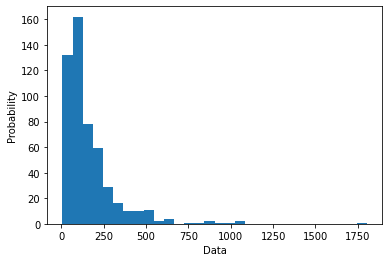

In [12]:
plt.hist(lengths, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

### class vs out-of-the-class tokens

In [13]:
def class_ratio(labels, entity):
    
    entity_num = picos_mapping[entity]
    
    out_of_span_counter = 0
    class_counter = 0
    
    for i in labels:
        lab_i = ast.literal_eval(i)
        if len(lab_i)>1:
            counts = collections.Counter( lab_i )
            counts = dict( counts )
            out_of_span_counter = out_of_span_counter + counts[0]
            if entity_num in counts:
                class_counter = class_counter + counts[entity_num]
                
    count_summary = {str(entity): class_counter, 'oos':out_of_span_counter}
                
    return count_summary

{'population': 469, 'oos': 82592}
{'intervention': 882, 'oos': 82592}
{'outcome': 879, 'oos': 82592}


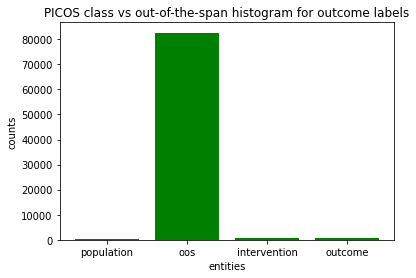

In [14]:
for x in [ 'population', 'intervention', 'outcome' ]:
    count_summary = class_ratio(df_clean.labels, x)
    print( count_summary )
    plt.bar(list(count_summary.keys()), count_summary.values(), color='g')
    plt.title(f'PICOS class vs out-of-the-span histogram for {x} labels')
    plt.xlabel('entities')
    plt.ylabel('counts')

### Inspect the PICO annotations

In [15]:
picos_colors_mapping = {'population': 'green', 'intervention': 'red', 'outcome': 'blue', 'oos':'black'}

In [16]:
def inspect_annots(entity, df_):
    terms_all = []
    terms_lengths = []

    for counter, (tok, lab) in enumerate(zip(df_.tokens.values, df_.labels.values)):
        
        tok = ast.literal_eval(tok)
        lab = ast.literal_eval(lab)
        
        
        captured_ind = []
        captured_cons_ind = []
        for counter_i, (t, l) in  enumerate(zip(tok, lab)):
            if l == picos_mapping[entity]:
                captured_ind.append( counter_i )

        for k, g in groupby(enumerate(captured_ind), lambda ix : ix[0] - ix[1]):
            label_indices = list(map(itemgetter(1), g))
            captured_cons_ind.append( label_indices )

        #print('\n-----------------------------------------------')

        for x in captured_cons_ind:
            #print(x)
            p_term = [tok[x_i] for x_i in x]
            terms_lengths.append( len(p_term) )
            p_term = ' '.join(p_term)
            terms_all.append( p_term )
            
            
    return terms_lengths, terms_all

In [17]:
def plot_common_words(description_list, n):
    # Assign the Counter instance `most_common` call to a variable:
    word_frequency = Counter(" ".join(description_list).split()).most_common(n)

    # `most_common` returns a list of (word, count) tuples
    words = [word for word, _ in word_frequency]
    counts = [counts for _, counts in word_frequency]
    
    fig = plt.figure(figsize=(7, 5))
    plt.bar(words, counts, color = picos_colors_mapping[picos_i])
    plt.title("10 most frequent tokens in the list")
    plt.ylabel("Frequency")
    plt.xlabel("Words")
    plt.xticks(rotation=45, ha='right')

    plt.show()

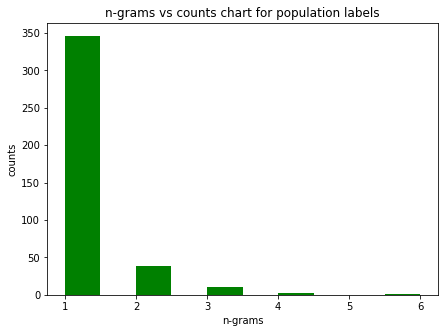

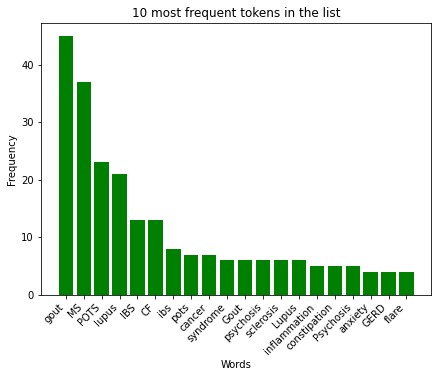

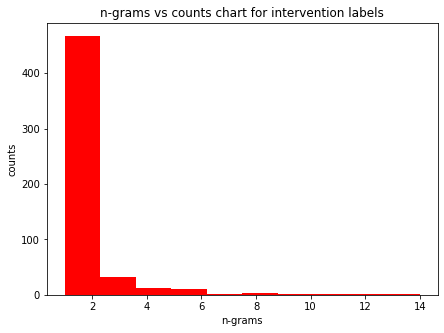

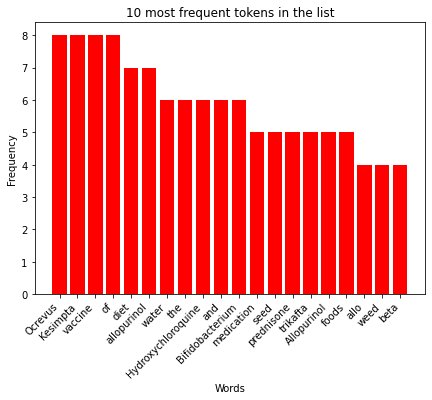

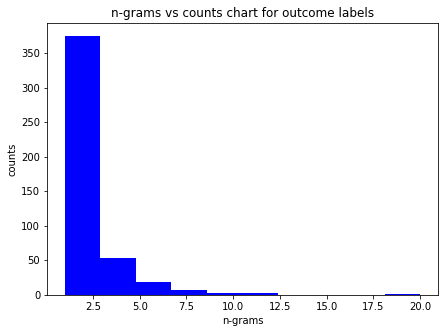

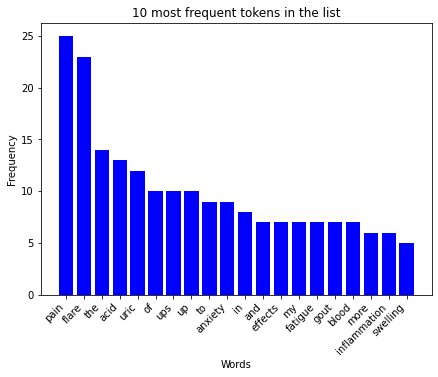

In [18]:
for picos_i in [ 'population', 'intervention', 'outcome' ]:
    
    terms_i_lengths, terms_i_all = inspect_annots(picos_i, df_clean)   

    fig = plt.figure(figsize=(7, 5))
    plt.hist( terms_i_lengths, bins=10, color = picos_colors_mapping[picos_i]) 
    plt.title(f'n-grams vs counts chart for {picos_i} labels')
    plt.xlabel('n-grams')
    plt.ylabel('counts')
        
    plt.show()
    
    plot_common_words(terms_i_all, 20)

Some notes: <br>

Participants: Lots of abbreviations. Consider them in the training and could use that in augmentation.

### Class overlap

In [19]:
def class_overlap(tokens, labels):
    
    par = []
    inter = []
    out = []
    oos = []
    
    for t, l in zip(tokens, labels):
        tok_i = ast.literal_eval(t)
        lab_i = ast.literal_eval(l)
        
        if len(lab_i)>1:
            
            for i,j in zip(tok_i, lab_i):
                if j == 0:
                    oos.append(i)
                if j == 1:
                    par.append(i)
                if j == 2:
                    inter.append(i)
                if j == 3:
                    out.append(i)

    return { 'participant': par, 'intervention': inter, 'outcome': out, 'oos': oos }


tokens_dict = class_overlap(df_clean.tokens, df_clean.labels)

In [20]:
for pair in itertools.combinations(['participant','intervention','outcome','oos'], 2):
    
    t1 = tokens_dict[ pair[0] ]
    t2 = tokens_dict[ pair[1] ]
    
    common = list(set(t1).intersection(t2))
    unique_1 = [ t for t in t1 if t not in t2 ]
    print( f'Common tokens between {pair[0]} and {pair[1]}: {common} \n' )
    print( f'Total number of common tokens between {pair[0]} and {pair[1]}: {len(common)} \n' )
    
    print( f'Unique tokens in {pair[0]} compared to {pair[1]}: {unique_1} \n' )
    print( f'Total number of unique tokens in {pair[0]} compared to {pair[1]}: {len(unique_1)} \n' )
    print(' -------------------------------------------------------------------- ')

Common tokens between participant and intervention: ['Cystic', 'blood', 'certain', 'high', 'Fibrosis', 'diet', 'Acid', 'ANA', 'acid', 'cf', 'cancer', 'covid', 'with', 'alcohol', 'healthy', 'stress', 'pylori', 'pots', 'bupropion', 'COVID', 'vaccines', 'Syndrome', 'tysabri', 'SLE', 'inflammation', 'tachycardia', 'patients'] 

Total number of common tokens between participant and intervention: 27 

Unique tokens in participant compared to intervention: ['gout', 'IBS', 'irritable', 'bowel', 'syndrome', 'management', 'Seizures', 'depression', 'anxiety', 'migraines', 'vertigo', 'MS', 'Hashimotos', 'RRMS', 'lupus', 'anxiety', 'POTS', 'POTS', 'gout', 'GERD', 'flare', 'up', 'lupus', 'anxiety', 'gout', 'IBS', 'gout', 'individuals', 'MS', 'Patients', 'gout', 'ibs', 'IBS', 'gout', 'autoimmune', 'PCOS', 'cortisol', 'pelvic', 'spasms', 'arthritis', 'fibro', 'bronchospasm', 'asthma', 'lupus', 'gout', 'Multiple', 'Sclerosis', 'MS', 'gout', 'MS', 'MS', 'POTS', 'CFers', 'CF', 'rash', 'LUPUS', 'infertili

Common tokens between intervention and oos: ['infantis', 'and', 'Bronchitol', 'blood', 'taking', 'proteins', 'o', 'steroids', 'adjust', 'root', 'every', 'Ocrevus', 'biopsies', 'gtube', 'Gaviscon', 'meat', 'Aleve', 'plant', 'mg', 'Thoracoscopic', 'UA', 'lignans', 'wearing', 'excessive', 'sucrose', 'longum', 'Thiazide', 'oral', 'cut', '500', 've', 'febuxostat', 'sugar', 'flue', '2', 'birth', 'going', 'slowly', 'Wim', 'psychotics', 'eating', 'PMDD', 'extract,', 'cherry', 'solution', 'injections', 'Prednisone', 'healthy', '80', 'Corlanor', 'masks', 'intake', 'donating', '(EBV)', 'creatine', 'urate', 'cold', 'beta', 'PPIs', 'Allo', 'coagulans', 'pot', 'ECG', 'little', 'Colchicine', 'marijuana', 'more', 'pineapple', 'drug', 'into', 'saline', 'red', 'sodium', 'olanzapine', 'allo', 'trikafta', 'n', 'fundoplication', 'full', 'vitamins', 'modified', 'wine', 'aspirin', 'weed', 'psychedelic', 'capsule', 'syrup', 'illness', 'generic', 'induced', 'control', 'psyllium', 'corn', 'Diovan', 'Epstein-Bar

### POS tag distributions

In [21]:
from spacy.glossary import GLOSSARY
lookup_dict = GLOSSARY

In [22]:
#lookup_dict

In [23]:
pos_2_num = dict( zip(lookup_dict.keys(), [*range(len(lookup_dict))]) )

In [24]:
def getPOStags(value):
    
    value = ast.literal_eval(value)
    pos = []
    
    for v in value:
        if type(v) == str:
            doc = en(v)
            tok_pos = [ token.tag_ for token in doc ]
            pos.append( tok_pos[0] )
        else:
            pos.append( 'N.A.' )

    return pos

def getPOSCoarsetags(value):
    
    value = ast.literal_eval(value)
    pos = []
    
    for v in value:
        if type(v) == str:
            doc = en(v)
            tok_pos = [ token.pos_ for token in doc ]
            pos.append( tok_pos[0] )
        else:
            pos.append( 'N.A.' )

    return pos

In [25]:
df_clean['pos'] = df_clean.tokens.progress_apply(getPOSCoarsetags)

  0%|          | 0/522 [00:00<?, ?it/s]

<ipython-input-25-82048b31a2f8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['pos'] = df_clean.tokens.progress_apply(getPOSCoarsetags)


In [26]:
df_clean['pos_fine'] = df_clean.tokens.progress_apply(getPOStags)

  0%|          | 0/522 [00:00<?, ?it/s]

<ipython-input-26-0f3c240b7bb9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['pos_fine'] = df_clean.tokens.progress_apply(getPOStags)


In [27]:
def get_pos_distribution(pos, lab, ent):
    
    pos_ent = []
    
    for p, j in zip( pos, lab ):
            
        #p = ast.literal_eval(i)
        l = ast.literal_eval(j)
    
        for p_i, l_i in zip(p, l):
            if l_i == picos_mapping[ent]:
                pos_ent.append( p_i )
    
    pos_counts = collections.Counter(pos_ent)
    pos_counts = dict( pos_counts.most_common(10) )
    
    fig = plt.figure(figsize=(12, 5))
    plt.bar(pos_counts.keys(), pos_counts.values(), color = picos_colors_mapping[ent])
    plt.title(f'POS tags counts in the {ent} class')
    plt.ylabel("Counts")
    plt.xlabel("POS tags")
    plt.xticks(rotation=45, ha='right')
    plt.show()
    
    # Distribution
    # create figure and axes
    pos_ent_num = [pos_2_num[i] for i in pos_ent]
    graph = sns.displot( data=pos_ent_num, stat='count', height=4, aspect=1.5, kde=True )
    
    return pos_counts

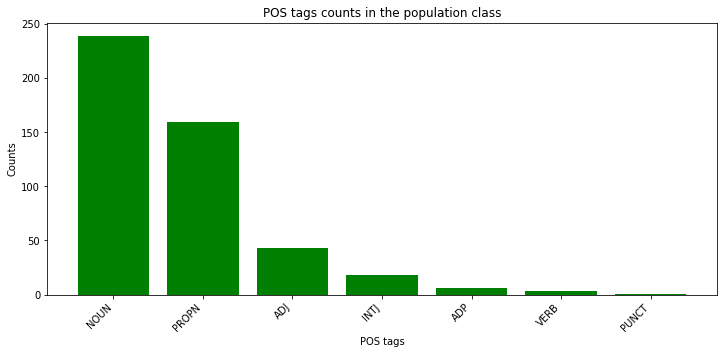

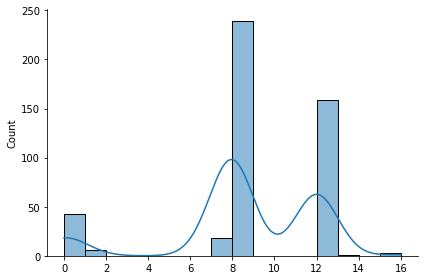

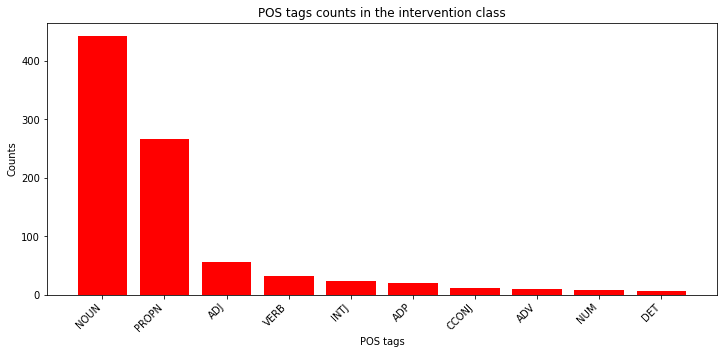

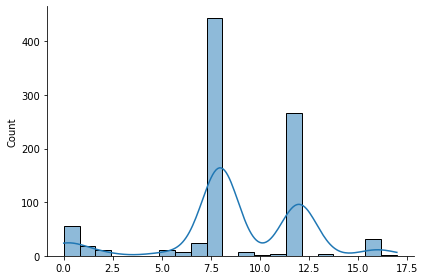

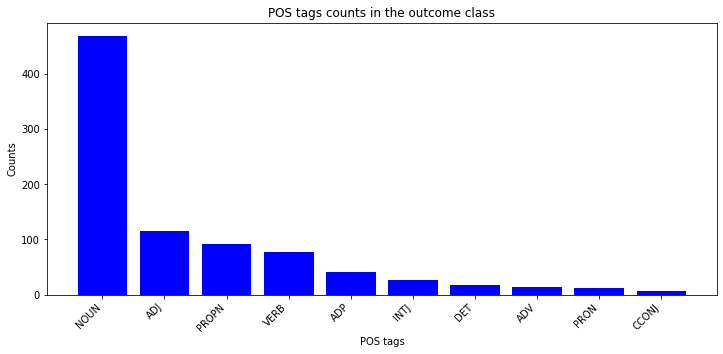

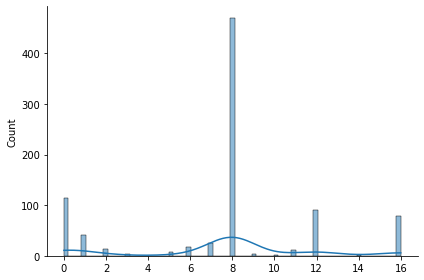

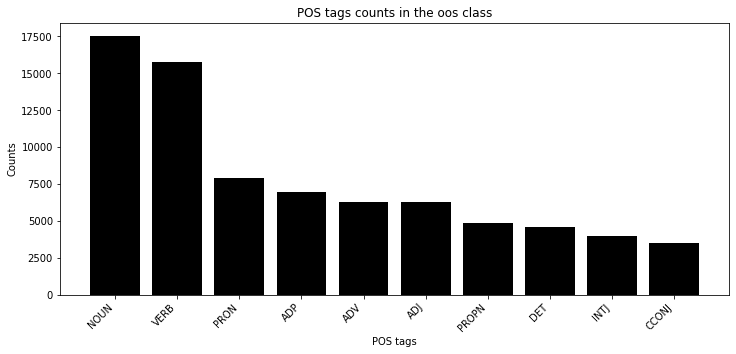

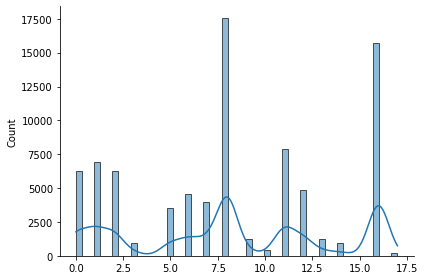

In [28]:
for i in ['population', 'intervention', 'outcome','oos']:
    get_pos_distribution( df_clean.pos, df_clean.labels , i )

Notes: POS tag distributions are different/discriminatory for the PICO tags

### Examine individual PICO

In [29]:
for picos_i in [ 'outcome' ]:
    
    _, terms_i_all = inspect_annots(picos_i, df_clean)
    
    #for i in list(set(terms_i_all)):
        #print(i)

### Examine social media posts

In [30]:
df_clean.shape

(522, 13)

In [31]:
for i, j in zip(df_clean.tokens, df_clean.labels):
    
    i = ast.literal_eval(i)
    j = ast.literal_eval(j)
    
    print( Counter(j) )
    
    for i_i, j_j in zip(i,j):
        print(i_i, '\t' , j_j)
    print('-------------------------------')

Counter({0: 175, 3: 6, 2: 1})
Tysabri 	 2
experiences 	 0
Hi 	 0
all 	 0
I 	 0
just 	 0
had 	 0
my 	 0
3rd 	 0
tysabri 	 0
infusion 	 0
today. 	 0
I 	 0
was 	 0
wondering 	 0
if 	 0
any 	 0
other 	 0
people 	 0
on 	 0
tysabri 	 0
notice 	 0
they 	 0
get 	 0
a 	 0
slight 	 0
worsening 	 3
of 	 3
old 	 3
symptoms 	 3
hours 	 0
after 	 0
infusion? 	 0
For 	 0
example, 	 0
normally 	 0
my 	 0
hug 	 0
only 	 0
is 	 0
around 	 0
the 	 0
front 	 0
of 	 0
my 	 0
chest, 	 0
but 	 0
its 	 0
wrapped 	 0
around 	 0
my 	 0
back 	 0
now 	 0
like 	 0
it 	 0
had 	 0
in 	 0
the 	 0
past. 	 0
Or 	 0
maybe 	 0
thats 	 0
just 	 0
what 	 0
back 	 3
pain 	 3
feels 	 0
like 	 0
So 	 0
perhaps 	 0
Im 	 0
just 	 0
getting 	 0
typical 	 0
side 	 0
effects. 	 0
I 	 0
never 	 0
have 	 0
any 	 0
side 	 0
effects 	 0
when 	 0
Im 	 0
monitored 	 0
in 	 0
the 	 0
hour 	 0
after 	 0
my 	 0
actual 	 0
IV 	 0
drip, 	 0
though. 	 0
I 	 0
read 	 0
an 	 0
old 	 0
thread 	 0
on 	 0
here 	 0
that 	 0
someone 	 0
said 	 0
she

masks 	 0
to 	 0
sacrifice 	 0
a 	 0
man. 	 0
And 	 0
we 	 0
will 	 0
be 	 0
spying 	 0
on 	 0
you 	 0
via 	 0
the 	 0
state 	 0
apparatus 	 0
which 	 0
we 	 0
control. 	 0
There 	 0
are 	 0
indeed 	 0
people 	 0
who 	 0
are 	 0
legitimately 	 0
psychotic. 	 0
However, 	 0
there 	 0
are 	 0
many 	 0
others, 	 0
who 	 0
being 	 0
told 	 0
they 	 0
are 	 0
psychotic, 	 0
are 	 0
instead 	 0
simply 	 0
chaffed 	 0
against 	 0
a 	 0
world 	 0
far 	 0
crazier, 	 0
backwards, 	 0
and 	 0
perverse 	 0
than 	 0
they. 	 0
-------------------------------
Counter({0: 25})
Pls 	 0
help. 	 0
I 	 0
dont 	 0
know 	 0
what 	 0
this 	 0
is 	 0
anymore. 	 0
Its 	 0
red, 	 0
dry/ 	 0
scaly, 	 0
itchy. 	 0
Not 	 0
sure 	 0
if 	 0
its 	 0
still 	 0
Seb 	 0
Derm 	 0
or 	 0
a 	 0
Lupus 	 0
symptom. 	 0
-------------------------------
Counter({0: 99, 1: 3})
Seizures 	 1
can 	 0
improve 	 0
your 	 0
mood, 	 0
Controlling 	 0
seizures 	 0
can 	 0
make 	 0
your 	 0
mood 	 0
worse. 	 0
My 	 0
neurologist 	 0
just

teenager 	 0
w 	 0
cf, 	 0
under 	 0
5 	 0
feet 	 0
tall, 	 0
and 	 0
my 	 0
weight 	 0
usually 	 0
fluctuates 	 0
between 	 0
95-101 	 0
lbs 	 0
as 	 0
of 	 0
right 	 0
now. 	 0
my 	 0
clinic 	 0
has 	 0
been 	 0
harassing 	 0
me 	 0
about 	 0
my 	 0
weight 	 0
recently 	 0
(despite 	 0
my 	 0
height 	 0
and 	 0
weight 	 0
having 	 0
been 	 0
unchanged 	 0
for 	 0
years 	 0
and 	 0
my 	 0
bmi 	 0
being 	 0
normal), 	 0
and 	 0
recently 	 0
they 	 0
brought 	 0
up 	 0
a 	 0
gtube 	 0
and 	 0
strongly 	 0
urged 	 0
me 	 0
to 	 0
consider 	 0
it. 	 0
i 	 0
flat 	 0
out 	 0
said 	 0
no 	 0
and 	 0
really 	 0
dont 	 0
plan 	 0
to 	 0
change 	 0
my 	 0
mind 	 0
because 	 0
i 	 0
really 	 0
dont 	 0
see 	 0
it 	 0
as 	 0
necessary 	 0
*right 	 0
now*. 	 0
anyways, 	 0
i 	 0
know 	 0
nobody 	 0
here 	 0
can 	 0
give 	 0
me 	 0
medical 	 0
advice 	 0
but 	 0
i 	 0
just 	 0
want 	 0
to 	 0
know 	 0
your 	 0
experiences 	 0
with 	 0
a 	 0
gtube 	 2
. 	 0
did 	 0
it 	 0
help? 	 0
was 	 0
it 	 0
p

the 	 0
root 	 0
cause 	 0
of 	 0
acid 	 0
reflux 	 0
since 	 0
it 	 0
just 	 0
doesn't 	 0
make 	 0
sense 	 0
to 	 0
me 	 0
that 	 0
young 	 0
people 	 0
with 	 0
normal 	 0
weights 	 0
etc. 	 0
can 	 0
be 	 0
suffering 	 0
like 	 0
this. 	 0
I 	 0
read 	 0
a 	 0
lot 	 0
of 	 0
healthy 	 0
20 	 0
years 	 0
old 	 0
in 	 0
this 	 0
reddit 	 0
community 	 0
that 	 0
have 	 0
struggled 	 0
with 	 0
GERD 	 0
for 	 0
years 	 0
and 	 0
years. 	 0
I 	 0
had 	 0
a 	 0
endoscope 	 0
last 	 0
year 	 0
that 	 0
showed 	 0
redness 	 0
in 	 0
my 	 0
esophagus 	 0
and 	 0
all 	 0
the 	 0
GI 	 0
doctor 	 0
did 	 0
was 	 0
hand 	 0
me 	 0
a 	 0
prescription 	 0
for 	 0
PPIs, 	 0
hello, 	 0
we 	 0
know 	 0
that 	 0
PPIs 	 0
should 	 0
not 	 0
be 	 0
used 	 0
longer 	 0
than 	 0
like 	 0
6 	 0
weeks 	 0
and 	 0
can 	 0
make 	 0
the 	 0
issue 	 0
worse. 	 0
Anyway, 	 0
I 	 0
want 	 0
to 	 0
know 	 0
what 	 0
tests 	 0
to 	 0
ask 	 0
for 	 0
at 	 0
the 	 0
GI 	 0
doctor 	 0
that 	 0
may 	 0
find 	 0
the 	

Counter({0: 338, 2: 5, 3: 1})
Anyone 	 0
has 	 0
local 	 0
injection 	 0
site 	 0
reactions 	 0
on 	 0
Kesimpta 	 2
? 	 0
Hi, 	 0
I 	 0
am 	 0
having 	 0
bad 	 0
reaction 	 0
on 	 0
Plegridy 	 2
(red 	 0
big 	 0
patches 	 0
that 	 0
itch 	 0
long 	 0
after 	 0
injection 	 0
was 	 0
administered). 	 0
It 	 0
has 	 0
been 	 0
few 	 0
months 	 0
and 	 0
it 	 0
hasn't 	 0
gotten 	 0
better. 	 0
I 	 0
didn't 	 0
have 	 0
this 	 0
on 	 0
Betaseron 	 2
, 	 0
and 	 0
since 	 0
both 	 0
are 	 0
interferon 	 0
I 	 0
compared 	 0
the 	 0
additives 	 0
in 	 0
these 	 0
injection 	 0
to 	 0
find 	 0
the 	 0
culprit. 	 0
What 	 0
**Plegridy** 	 0
injections 	 0
have 	 0
extra 	 0
apart 	 0
from 	 0
**Betaferon 	 0
(Betaseron)** 	 0
is 	 0
*L-*[*arginine*](https://www.rxlist.com/script/main/art.asp?articlekey=7006) 	 0
*HCl* 	 0
[*sodium 	 0
acetate*](https://www.rxlist.com/sodium-acetate-drug.htm) 	 0
*trihydrate* 	 0
*glacial* 	 0
[*acetic 	 0
acid*](https://www.rxlist.com/script/main/art.asp?artic

Exercise 	 0
induced 	 0
asthma 	 0
or 	 0
pots?? 	 0
Sorry 	 0
but 	 0
I've 	 0
recently 	 0
been 	 0
walking 	 0
everyday 	 0
for 	 0
my 	 0
arthritis 	 1
and 	 0
fibro 	 1
, 	 0
and 	 0
noticed 	 0
when 	 0
I 	 0
sit 	 0
down 	 0
and 	 0
chill 	 0
after, 	 0
I 	 0
get 	 0
a 	 0
tight 	 0
and 	 0
weak 	 0
chest 	 0
and 	 0
my 	 0
back 	 0
and 	 0
chest 	 0
and 	 0
ribs 	 0
ache 	 3
(basically 	 0
my 	 0
whole 	 0
body 	 0
aches) 	 0
and 	 0
I 	 0
get 	 0
tired 	 3
and 	 0
slightly 	 0
dizzy. 	 0
I 	 0
have 	 0
tachycardia 	 2
and 	 0
take 	 0
two 	 0
beta 	 2
blockers 	 2
in 	 0
the 	 0
morning 	 0
and 	 0
again 	 0
at 	 0
night. 	 0
I 	 0
always 	 0
forget 	 0
to 	 0
take 	 0
my 	 0
beta 	 0
blockers 	 0
in 	 0
the 	 0
morning 	 0
before 	 0
I 	 0
exercise 	 0
and 	 0
end 	 0
up 	 0
taking 	 0
them 	 0
after 	 0
I've 	 0
already 	 0
done 	 0
my 	 0
walk. 	 0
Then 	 0
I 	 0
just 	 0
feel 	 0
completely 	 0
pooped 	 0
and 	 0
have 	 0
to 	 0
lie 	 0
down 	 0
while 	 0
my 	 0
body 	 0


ekg. 	 0
it 	 0
came 	 0
back 	 0
saying 	 0
i 	 0
was 	 0
in 	 0
A 	 3
Fib 	 3
. 	 0
ive 	 0
never 	 0
had 	 0
A 	 0
Fib 	 0
before, 	 0
just 	 0
SVT 	 0
and 	 0
PVCs/PACs. 	 0
i 	 0
sat 	 0
down 	 0
for 	 0
20 	 0
minutes, 	 0
checked 	 0
it 	 0
again, 	 0
was 	 0
still 	 0
in 	 0
A 	 0
Fib. 	 0
i 	 0
was 	 0
warned 	 0
that 	 0
Corlanor 	 2
can 	 0
cause 	 0
that 	 0
so 	 0
i 	 0
called 	 0
cardiology 	 0
and 	 0
had 	 0
them 	 0
send 	 0
a 	 0
message 	 0
to 	 0
my 	 0
doctor 	 0
because 	 0
i 	 0
also 	 0
have 	 0
a 	 0
chronically 	 0
high 	 0
D-dimer 	 0
and 	 0
A 	 0
Fib 	 0
puts 	 0
anyone 	 0
at 	 0
greater 	 0
risk 	 0
of 	 0
clots. 	 0
my 	 0
internship 	 0
started 	 0
today, 	 0
going 	 0
well, 	 0
but 	 0
i 	 0
checked 	 0
it 	 0
quickly 	 0
before 	 0
eating 	 0
lunch 	 0
and 	 0
now 	 0
its 	 0
unclassified 	 0
which 	 0
is 	 0
a 	 0
result 	 0
i 	 0
get 	 0
pretty 	 0
often, 	 0
so 	 0
im 	 0
going 	 0
to 	 0
see 	 0
what 	 0
the 	 0
cardiology 	 0
nurse 	 0
thinks 	 0

on 	 0
doing. 	 0
Ive 	 0
had 	 0
worsening 	 0
stomach 	 0
problems 	 0
for 	 0
the 	 0
last 	 0
five 	 0
years 	 0
or 	 0
so, 	 0
especially 	 0
bad 	 0
in 	 0
the 	 0
last 	 0
year. 	 0
Im 	 0
wondering 	 0
if 	 0
I 	 0
could 	 0
be 	 0
experiencing 	 0
constipation/gas 	 0
issues 	 0
from 	 0
this 	 0
being 	 0
a 	 0
carrier? 	 0
Curious 	 0
if 	 0
any 	 0
carriers 	 0
on 	 0
here 	 0
have 	 0
experienced 	 0
that 	 0
sort 	 0
of 	 0
thing. 	 0
**edit** 	 0
Ive 	 0
had 	 0
a 	 0
full 	 0
sequencing 	 0
done 	 0
and 	 0
I 	 0
am 	 0
heterozygous, 	 0
I 	 0
only 	 0
have 	 0
one 	 0
(known) 	 0
mutation 	 0
. 	 0
-------------------------------
Counter({0: 262, 3: 2, 1: 1})
Update 	 0
on 	 0
my 	 0
First 	 0
Gout 	 1
Hey 	 0
everyone, 	 0
so 	 0
I 	 0
posted 	 0
in 	 0
here 	 0
about 	 0
a 	 0
week 	 0
ago 	 0
for 	 0
the 	 0
first 	 0
time 	 0
and 	 0
first 	 0
of 	 0
all 	 0
I 	 0
wanted 	 0
to 	 0
thank 	 0
you 	 0
all 	 0
for 	 0
the 	 0
support 	 0
and 	 0
all 	 0
the 	 0
questi

real., 	 0
etc. 	 0
Ill 	 0
try 	 0
to 	 0
talk 	 0
to 	 0
my 	 0
dad 	 0
about 	 0
it 	 0
next 	 0
but 	 0
hes 	 0
not 	 0
big 	 0
on 	 0
mental 	 0
health, 	 0
so. 	 0
Thank 	 0
you 	 0
to 	 0
all 	 0
the 	 0
people 	 0
that 	 0
helped 	 0
me 	 0
out! 	 0
I 	 0
really 	 0
appreciate 	 0
you 	 0
all 	 0
-------------------------------
Counter({0: 53, 2: 2})
Im 	 0
pregnant 	 0
and 	 0
scared. 	 0
Any 	 0
advice? 	 0
First 	 0
pregnancy, 	 0
8 	 0
weeks 	 0
in! 	 0
Im 	 0
taking 	 0
lamotrigine 	 0
(which 	 0
is 	 0
safe 	 0
for 	 0
pregnancies) 	 0
and 	 0
my 	 0
seizures 	 0
are 	 0
controlled. 	 0
Also, 	 0
taking 	 0
folic 	 2
acid 	 2
and 	 0
following 	 0
all 	 0
my 	 0
epileptologists 	 0
orders. 	 0
I 	 0
would 	 0
like 	 0
to 	 0
hear 	 0
some 	 0
real 	 0
life 	 0
experiences. 	 0
What 	 0
was 	 0
your 	 0
pregnancy 	 0
like 	 0
with 	 0
epilepsy? 	 0
Do 	 0
you 	 0
have 	 0
any 	 0
advice? 	 0
-------------------------------
Counter({0: 40, 3: 1, 1: 1})
MS 	 0
Vaccine 	 3
to

the 	 0
fact 	 0
that 	 0
every 	 0
time 	 0
I 	 0
show 	 0
a 	 0
symptom, 	 0
Im 	 0
reminded 	 0
that 	 0
my 	 0
body 	 0
has 	 0
attacked 	 0
that 	 0
delicate 	 0
myelin 	 0
sheath 	 0
around 	 0
my 	 0
nerves 	 0
and 	 0
that 	 0
that 	 0
process 	 0
will 	 0
continue, 	 0
even 	 0
if 	 0
its 	 0
slowed 	 0
down 	 0
by 	 0
Ocrevus. 	 0
How 	 0
am 	 0
I 	 0
supposed 	 0
to 	 0
ever 	 0
be 	 0
okay 	 0
with 	 0
that? 	 0
Mom 	 0
said 	 0
that 	 0
somed 	 0
ay 	 2
the 	 2
trea 	 2
tments 	 0
wont 	 0
be 	 0
so 	 0
hard 	 0
on 	 0
me 	 0
emotionally. 	 0
She 	 0
says 	 0
it 	 0
to 	 0
make 	 0
me 	 0
feel 	 0
better 	 0
because 	 0
she 	 0
doesnt 	 0
like 	 0
to 	 0
see 	 0
any 	 0
one 	 3
in 	 0
pain. 	 0
It 	 0
doesnt 	 0
help. 	 0
And 	 0
the 	 0
most 	 0
difficult 	 0
part 	 0
of 	 0
this 	 0
whole 	 0
thing 	 0
is 	 0
that 	 0
nothing 	 0
helps. 	 0
Truly. 	 0
Im 	 0
beyond 	 0
grateful 	 0
for 	 0
my 	 0
doctors 	 0
and 	 0
the 	 0
treatments 	 0
and 	 0
everything, 	 0
but 	 0


Google 	 0
helped 	 0
as 	 0
did 	 0
confirmation 	 0
with 	 0
doctor 	 0
. 	 0
Since 	 0
then 	 0
I'm 	 0
acutely 	 0
when 	 0
I 	 0
am 	 0
about 	 0
to 	 0
get 	 0
it 	 0
(that 	 0
tingling 	 0
feeling 	 0
plus 	 0
growing 	 0
lump 	 0
.. 	 0
What 	 0
is 	 0
that 	 0
called?) 	 0
on 	 0
my 	 0
left 	 0
big 	 0
toe. 	 0
I've 	 0
had 	 0
it 	 0
come 	 0
and 	 0
go 	 0
maybe 	 0
3 	 0
to 	 0
4 	 0
times 	 0
since 	 0
first 	 0
time 	 0
(not 	 0
enough 	 0
water 	 0
meat 	 0
dairy 	 0
very 	 0
little 	 0
vege 	 0
fruit 	 0
diet 	 0
did 	 0
it..). 	 0
Have 	 0
tried 	 0
change 	 0
diet 	 0
but 	 0
it's 	 0
slow 	 0
and 	 0
been 	 0
using 	 0
tart 	 0
cherry 	 0
(juice 	 0
seems 	 0
to 	 0
work 	 0
better 	 0
than 	 0
capsules), 	 0
ibrufen, 	 0
plenty 	 0
fruit 	 0
and 	 0
vege 	 0
(leaving 	 0
out 	 0
spinach... 	 0
Never 	 0
liked 	 0
it 	 0
anyway 	 0
). 	 0
Drinking 	 0
lot 	 0
more 	 0
water. 	 0
Personally 	 0
found 	 0
soft 	 0
drinks 	 0
main 	 0
trigger 	 0
for 	 0
me. 	 0
How 	 

I 	 0
am 	 0
coming 	 0
from. 	 0
I 	 0
am 	 0
one 	 0
of 	 0
you. 	 0
I 	 0
suffered 	 0
with 	 0
this 	 0
for 	 0
a 	 0
long 	 0
time 	 0
thinking 	 0
I 	 0
could 	 0
manage 	 0
it. 	 0
I 	 0
didn't 	 0
want 	 0
to 	 0
take 	 0
life 	 0
long 	 0
medication. 	 0
Maybe 	 0
you 	 0
can 	 0
manage 	 0
it 	 0
- 	 0
and 	 0
please 	 0
come 	 0
back 	 0
here 	 0
and 	 0
tell 	 0
us 	 0
what 	 0
you 	 0
are 	 0
doing 	 0
if 	 0
you 	 0
find 	 0
it 	 0
helpful. 	 0
I 	 0
am 	 0
not 	 0
against 	 0
alternative 	 0
treatment. 	 0
What 	 0
I 	 0
am 	 0
trying 	 0
to 	 0
do 	 0
is 	 0
spread 	 0
a 	 0
better 	 0
understanding 	 0
of 	 0
the 	 0
disease 	 0
and 	 0
hopefully 	 0
some 	 0
of 	 0
you 	 0
won't 	 0
have 	 0
to 	 0
suffer 	 0
for 	 0
10 	 0
years 	 0
before 	 0
seeking 	 0
help. 	 0
-------------------------------
Counter({0: 113, 3: 5, 1: 2, 2: 1})
Alcohol 	 2
causing 	 0
tingling 	 3
and 	 3
tightness 	 3
in 	 3
face 	 3
I 	 0
have 	 0
never 	 0
been 	 0
a 	 0
heavy 	 0
drinker. 	 0

the 	 0
big 	 0
toe 	 0
on 	 0
both 	 0
feet 	 0
and 	 0
my 	 0
right 	 0
ankle. 	 0
All 	 0
the 	 0
advice 	 0
you 	 0
can 	 0
find 	 0
online 	 0
states 	 0
that 	 0
acute 	 0
attacks 	 0
last 	 0
between 	 0
3 	 0
to 	 0
14 	 0
days, 	 0
yet 	 0
every 	 0
single 	 0
one 	 0
of 	 0
mine 	 0
has 	 0
lasted 	 0
longer 	 0
despite 	 0
medication. 	 0
Just 	 0
wondered 	 0
if 	 0
anyone 	 0
else 	 0
experiences 	 0
this 	 0
as 	 0
I 	 0
am 	 0
feeling 	 0
very 	 0
sorry 	 0
for 	 0
myself! 	 0
-------------------------------
Counter({0: 479, 1: 1, 3: 1})
80% 	 0
of 	 0
people 	 0
diagnosed 	 0
with 	 0
IBS 	 1
have 	 0
Sibo 	 3
. 	 0
Please 	 0
read 	 0
the 	 0
book 	 0
IBS 	 0
A 	 0
New 	 0
Solution 	 0
by 	 0
Dr. 	 0
Pimental. 	 0
He 	 0
explains 	 0
everything 	 0
Im 	 0
about 	 0
to 	 0
say 	 0
and 	 0
in 	 0
further 	 0
detail 	 0
based 	 0
on 	 0
scientific 	 0
research. 	 0
I 	 0
feel 	 0
I 	 0
wouldnt 	 0
be 	 0
doing 	 0
my 	 0
do-diligence 	 0
if 	 0
I 	 0
didnt 	 0
speak 	 0
u

gotten 	 0
me 	 0
a 	 0
little 	 0
depressed 	 0
as 	 0
I 	 0
havent 	 0
been 	 0
able 	 0
to 	 0
move 	 0
and 	 0
my 	 0
weight 	 0
loss 	 0
journey 	 0
has 	 0
come 	 0
to 	 0
a 	 0
grinding 	 0
halt. 	 0
Any 	 0
information 	 0
or 	 0
shared 	 0
experiences 	 0
would 	 0
be 	 0
greatly 	 0
appreciated. 	 0
-------------------------------
Counter({0: 84, 3: 2, 2: 1, 1: 1})
Allopurinol 	 0
side 	 0
effects 	 0
youve 	 0
experienced? 	 0
From 	 0
what 	 0
I 	 0
have 	 0
read 	 0
here 	 0
and 	 0
online, 	 0
it 	 0
sounds 	 0
like 	 0
taking 	 0
allopurino 	 2
l 	 0
is 	 0
likely 	 0
the 	 0
best 	 0
option 	 0
for 	 0
most 	 0
people 	 0
suffering 	 0
from 	 0
gout 	 1
, 	 0
even 	 0
if 	 0
they 	 0
also 	 0
try 	 0
to 	 0
follow 	 0
a 	 0
gout 	 0
diet. 	 0
I 	 0
have 	 0
a 	 0
different 	 0
medication 	 0
I 	 0
take 	 0
daily, 	 0
so 	 0
Im 	 0
not 	 0
bothered 	 0
by 	 0
having 	 0
to 	 0
take 	 0
a 	 0
pill 	 0
every 	 0
day, 	 0
but 	 0
I 	 0
am 	 0
concerned 	 0
about 	 0
possibl

never 	 0
really 	 0
had 	 0
acid 	 0
reflux 	 0
life, 	 0
however 	 0
from 	 0
Christmas 	 0
morning 	 0
until 	 0
now 	 0
it's 	 0
been 	 0
pretty 	 0
constant. 	 0
Everything 	 0
I 	 0
eat 	 0
seems 	 0
to 	 0
be 	 0
giving 	 0
me 	 0
acid 	 0
reflux 	 0
and 	 0
I 	 0
can't 	 0
even 	 0
drink 	 0
water 	 0
without 	 0
burping 	 0
and 	 0
tasting 	 0
acid 	 0
at 	 0
the 	 0
back 	 0
my 	 0
throat. 	 0
I 	 0
feel 	 0
totally 	 0
fine 	 0
in 	 0
the 	 0
morning 	 0
and 	 0
by 	 0
around 	 0
mid 	 0
afternoon 	 0
I'm 	 0
having 	 0
acid 	 0
reflux 	 0
that 	 0
will 	 0
persist 	 0
until 	 0
I 	 0
go 	 0
to 	 0
bed 	 0
- 	 0
I 	 0
do 	 0
feel 	 0
fine 	 0
when 	 0
laying 	 0
down. 	 0
I 	 0
do 	 0
take 	 0
Apixaban 	 2
and 	 0
have 	 0
done 	 0
for 	 0
5 	 0
months 	 0
to 	 0
treat 	 0
a 	 0
DVT 	 0
and 	 0
have 	 0
read 	 0
this 	 0
can 	 0
cause 	 0
reflux 	 3
symptoms 	 3
. 	 0
Have 	 0
been 	 0
unable 	 0
to 	 0
check 	 0
if 	 0
I 	 0
can 	 0
take 	 0
Omeprazole 	 0
with 	 0
this 	 0

how 	 0
I 	 0
was 	 0
previously 	 0
treated 	 0
in 	 0
the 	 0
past. 	 0
-------------------------------
Counter({0: 116})
The 	 0
world 	 0
is 	 0
a 	 0
recreation 	 0
of 	 0
your 	 0
brain, 	 0
spinning 	 0
ballerina 	 0
proves 	 0
it 	 0
This 	 0
ballerina 	 0
spins 	 0
different 	 0
directions 	 0
based 	 0
upon 	 0
your 	 0
mental 	 0
activity. 	 0
If 	 0
we 	 0
as 	 0
a 	 0
group 	 0
witness 	 0
this 	 0
image 	 0
and 	 0
individually 	 0
we 	 0
each 	 0
see 	 0
her 	 0
spin 	 0
a 	 0
different 	 0
way 	 0
and 	 0
at 	 0
different 	 0
times. 	 0
This 	 0
effect 	 0
implies 	 0
life 	 0
is 	 0
a 	 0
recreation 	 0
of 	 0
sensory 	 0
inputs 	 0
to 	 0
the 	 0
brain 	 0
such 	 0
as 	 0
visual 	 0
and 	 0
that 	 0
we 	 0
all 	 0
solely 	 0
generate 	 0
the 	 0
world 	 0
around 	 0
us 	 0
by 	 0
ourselves. 	 0
We 	 0
all 	 0
see 	 0
the 	 0
same 	 0
image. 	 0
Yet 	 0
it 	 0
differs 	 0
from 	 0
one 	 0
to 	 0
the 	 0
next. 	 0
This 	 0
implies 	 0
our 	 0
sensory 	 0
inputs 	 0
and 

https://preview.redd.it/c5eewizbai181.png?width=750&format=png&auto=webp&s=1f96ccef5023c5a08f18d180fade68fab89c2e23 	 0
-------------------------------
Counter({0: 42, 1: 2, 2: 1})
PPI 	 0
for 	 0
20 	 0
years. 	 0
Now, 	 0
worried 	 0
about 	 0
effects. 	 0
I've 	 0
been 	 0
taking 	 0
Nexium 	 2
for 	 0
20 	 0
years 	 0
this 	 0
month. 	 0
All 	 0
the 	 0
news 	 0
about 	 0
it 	 0
possibly 	 0
causing 	 0
stomach 	 0
cancer 	 1
and 	 0
dementia 	 1
are 	 0
bothering 	 0
me. 	 0
Anyone 	 0
else 	 0
long 	 0
hauled 	 0
ppis? 	 0
Has 	 0
your 	 0
Doc 	 0
said 	 0
anything? 	 0
Mine 	 0
seems 	 0
completely 	 0
unconcerned. 	 0
-------------------------------
Counter({0: 100, 1: 4})
POTS 	 0
and 	 0
Exercise- 	 0
your 	 0
advice 	 0
I 	 0
have 	 0
POTS 	 1
/ 	 0
Dysautonomia 	 1
/ 	 0
Vasovagal 	 1
Syncope 	 1
- 	 0
been 	 0
given 	 0
every 	 0
name 	 0
under 	 0
the 	 0
sun. 	 0
This 	 0
semester, 	 0
I'm 	 0
really 	 0
trying 	 0
to 	 0
get 	 0
in 	 0
better 	 0
physical 	 0
shape, 	 0

6.4, 	 0
so 	 0
my 	 0
Dr 	 0
recently 	 0
upped 	 0
it 	 0
to 	 0
300 	 0
mg. 	 0
My 	 0
pain 	 0
which 	 0
had 	 0
commonly 	 0
been 	 0
in 	 0
my 	 0
ankle, 	 0
was 	 0
well 	 0
managed 	 0
at 	 0
200 	 0
Mg, 	 0
until 	 0
2 	 0
months 	 0
ago 	 0
when 	 0
I 	 0
broke/sprained 	 0
that 	 0
ankle, 	 0
which 	 0
caused 	 0
an 	 0
awful 	 0
gout 	 0
and 	 0
inflammation 	 0
flareup 	 0
about 	 0
3 	 0
days 	 0
after 	 0
the 	 0
break, 	 0
which 	 0
would 	 0
come 	 0
and 	 0
go 	 0
for 	 0
about 	 0
4 	 0
weeks 	 0
while 	 0
it 	 0
healed 	 0
and 	 0
while 	 0
I 	 0
couldn't 	 0
exercise. 	 0
Then 	 0
about 	 0
the 	 0
time 	 0
that 	 0
pain 	 0
went 	 0
away, 	 0
I 	 0
got 	 0
a 	 0
swelling 	 3
on 	 0
the 	 0
tip 	 0
of 	 0
my 	 0
elbow, 	 0
and 	 0
it 	 0
hurts 	 0
to 	 0
rest 	 0
weight 	 0
on 	 0
it. 	 0
At 	 0
first 	 0
it 	 0
was 	 0
warm 	 0
but 	 0
now 	 0
its 	 0
just 	 0
swollen 	 0
and 	 0
tender. 	 0
I 	 0
thought 	 0
the 	 0
gout 	 0
had 	 0
moved 	 0
to 	 0
my 	 0
elbow,

or 	 0
medicine 	 0
regimine. 	 0
NOTE 	 0
I 	 0
am 	 0
not 	 0
a 	 0
medical 	 0
professional. 	 0
These 	 0
is 	 0
just 	 0
my 	 0
personal 	 0
experience. 	 0
-------------------------------
Counter({0: 219, 1: 4, 3: 4, 2: 3})
New 	 0
Lab 	 0
results 	 0
have 	 0
me 	 0
worried 	 0
Ive 	 0
only 	 0
been 	 0
on 	 0
Ocrevus 	 2
for 	 0
about 	 0
6 	 0
months. 	 0
I 	 0
had 	 0
my 	 0
first 	 0
infusion 	 2
in 	 0
September. 	 0
So 	 0
today 	 0
I 	 0
got 	 0
some 	 0
routine 	 0
blood 	 0
work 	 0
done. 	 0
The 	 0
lab 	 0
reports 	 0
came 	 0
back 	 0
showing 	 0
I 	 0
had 	 0
very 	 0
high 	 0
WBC 	 1
, 	 0
high 	 0
neutrophils 	 1
absolute, 	 0
and 	 0
low 	 0
lymphocytes 	 1
. 	 0
(Google 	 0
says 	 0
that 	 0
it 	 0
usually 	 0
indicates 	 0
the 	 0
body 	 0
is 	 0
fighting 	 0
an 	 0
infection 	 0
or 	 0
the 	 0
big 	 0
C.) 	 0
I 	 0
had 	 0
just 	 0
gotten 	 0
my 	 0
wisdom 	 0
tooth 	 0
removed 	 0
yesterday 	 0
and 	 0
prior 	 0
to 	 0
that 	 0
I 	 0
was 	 0
on 	 0
antibiotic

did 	 0
the 	 0
following: 	 0
- 	 0
recommended 	 0
I 	 0
go 	 0
on 	 0
a 	 0
gout 	 0
diet 	 0
- 	 0
recommended 	 0
I 	 0
stopped 	 0
drinking 	 0
(I 	 0
was 	 0
having 	 0
about 	 0
4-6 	 0
glasses 	 0
of 	 0
wine 	 0
a 	 0
week 	 0
- 	 0
thanks 	 0
pandemic!) 	 0
- 	 0
prescribed 	 0
a 	 0
daily 	 0
dose 	 0
of 	 0
100mg 	 0
Allopurinol 	 0
- 	 0
prescribed 	 0
Colchicine 	 0
for 	 0
acute 	 0
flare 	 0
ups 	 0
- 	 0
prescribed 	 0
Indomethacine 	 0
for 	 0
acute 	 0
flare 	 0
ups 	 0
I 	 0
did 	 0
everything 	 0
I 	 0
was 	 0
told, 	 0
and 	 0
for 	 0
8 	 0
months 	 0
I 	 0
was 	 0
mostly 	 0
fine, 	 0
with 	 0
two 	 0
exceptions: 	 0
1. 	 0
The 	 0
once 	 0
a 	 0
month 	 0
Id 	 0
have 	 0
a 	 0
single 	 0
drink, 	 0
I 	 0
would 	 0
turn 	 0
flush. 	 0
Possibly 	 0
from 	 0
liver 	 0
function 	 0
side 	 0
effects 	 0
from 	 0
Fenofibrate? 	 0
2. 	 0
My 	 0
toe 	 0
never 	 0
was 	 0
100% 	 0
normal, 	 0
but 	 0
there 	 0
was 	 0
no 	 0
pain 	 0
and 	 0
it 	 0
was 	 0
95% 	 0
norma

read 	 0
everywhere 	 0
that 	 0
says 	 0
don't 	 0
drink 	 0
water 	 0
2-3 	 0
hrs 	 0
after 	 0
meals, 	 0
even 	 0
my 	 0
doctor 	 0
said 	 0
don't 	 0
drink 	 0
water 	 0
3 	 0
hrs 	 0
after 	 0
meals, 	 0
so 	 0
if 	 0
we 	 0
count 	 0
we 	 0
can 	 0
see 	 0
we 	 0
don't 	 0
drink 	 0
water 	 0
for 	 0
10 	 0
hours 	 0
in 	 0
a 	 0
day 	 0
even 	 0
after 	 0
a 	 0
dinner 	 0
we 	 0
just 	 0
have 	 0
almost 	 0
1 	 0
hour 	 0
to 	 0
drink 	 0
water 	 0
and 	 0
after 	 0
that 	 0
we 	 0
can't 	 0
because 	 0
of 	 0
going 	 0
to 	 0
bed. 	 0
So 	 0
i 	 0
wonder 	 0
this 	 0
condition 	 0
causes 	 0
dehydration 	 0
or 	 0
not? 	 0
(I 	 0
didn't 	 0
mention 	 0
about 	 0
athletics 	 0
because 	 0
they 	 0
need 	 0
more 	 0
water 	 0
tho). 	 0
-------------------------------
Counter({0: 77, 2: 1})
C1q 	 0
complement 	 0
deficiency 	 0
Posting 	 0
one 	 0
more 	 0
time 	 0
because 	 0
I 	 0
am 	 0
looking 	 0
for 	 0
information 	 0
about 	 0
this 	 0
disease. 	 0
My 	 0
2 	 0
years 	 0


so 	 0
heavily 	 0
on 	 0
me 	 0
I 	 0
wanted 	 0
to 	 0
see 	 0
if 	 0
anyone 	 0
here 	 0
has 	 0
experience 	 0
with 	 0
this. 	 0
I 	 0
also 	 0
know 	 0
it's 	 0
different 	 0
for 	 0
everyone, 	 0
especially 	 0
because 	 0
I 	 0
don't 	 0
know 	 0
what 	 0
my 	 0
body 	 0
will 	 0
be 	 0
like/be 	 0
capable 	 0
of 	 0
after 	 0
pregnancy. 	 0
Anyway, 	 0
thanks 	 0
for 	 0
listening. 	 0
-------------------------------
Counter({0: 200, 2: 6, 3: 4})
Trikafta 	 2
and 	 0
GI 	 0
issues 	 0
I 	 0
have 	 0
seen 	 0
many 	 0
posts 	 0
related 	 0
to 	 0
GI 	 0
issues 	 0
& 	 0
trikafta 	 0
from 	 0
around 	 0
a 	 0
year 	 0
ago. 	 0
I 	 0
was 	 0
hoping 	 0
to 	 0
revisit 	 0
this 	 0
topic 	 0
in 	 0
order 	 0
to 	 0
hear 	 0
updates 	 0
(hopefully 	 0
positive) 	 0
from 	 0
those 	 0
who 	 0
suffered 	 0
from 	 0
GI 	 3
issues 	 3
when 	 0
starting 	 0
trikafta. 	 0
Mainly, 	 0
what 	 0
exactly 	 0
were 	 0
your 	 0
symptoms 	 0
and 	 0
what 	 0
worked 	 0
to 	 0
resolve 	 0
them? 	

in 	 0
addition 	 0
to 	 0
my 	 0
neurologist 	 0
for 	 0
my 	 0
pots. 	 0
well 	 0
i 	 0
went 	 0
to 	 0
the 	 0
new 	 0
cardiologist 	 0
with 	 0
a 	 0
bit 	 0
of 	 0
hope 	 0
that 	 0
maybe 	 0
they 	 0
could 	 0
help 	 0
and 	 0
he 	 0
basically 	 0
said 	 0
that 	 0
i 	 0
dont 	 0
have 	 0
pots, 	 0
im 	 0
just 	 0
dehydrated 	 3
. 	 0
completely 	 0
ignored 	 0
my 	 0
charts 	 0
and 	 0
diagnoses, 	 0
blood 	 0
tests, 	 0
doctors 	 0
notes, 	 0
etc. 	 0
told 	 0
me 	 0
to 	 0
drink 	 0
more 	 0
water 	 0
and 	 0
sent 	 0
me 	 0
on 	 0
my 	 0
way. 	 0
-------------------------------
Counter({0: 90, 3: 3, 1: 3, 2: 1})
Does 	 0
trikafta 	 0
help 	 0
the 	 0
pancreas? 	 0
I 	 0
was 	 0
wondering, 	 0
since 	 0
trikafta 	 2
helps 	 0
unclog 	 0
the 	 0
lungs, 	 0
does 	 0
it 	 0
help 	 3
the 	 3
pancreas 	 3
also? 	 0
I 	 0
know 	 0
the 	 0
pancreas 	 0
is 	 0
one 	 0
of 	 0
the 	 0
first 	 0
things 	 0
to 	 0
really 	 0
get 	 0
damaged 	 0
at 	 0
a 	 0
young 	 0
age 	 0
but 	 0
Im 	 

it?please 	 0
no 	 0
hearsay, 	 0
I 	 0
read 	 0
a 	 0
lot 	 0
of 	 0
speculation 	 0
why 	 0
it 	 0
couldnt 	 0
be 	 0
trusted 	 0
from 	 0
people 	 0
who 	 0
didnt 	 0
even 	 0
set 	 0
foot 	 0
into 	 0
the 	 0
business. 	 0
Let 	 0
me 	 0
know 	 0
what 	 0
helped 	 0
you. 	 0
She 	 0
was 	 0
evaluated 	 0
at 	 0
Mayo 	 0
with 	 0
no 	 0
more 	 0
advice 	 0
as 	 0
the 	 0
above 	 0
stated. 	 0
Thank 	 0
you 	 0
-------------------------------
Counter({0: 130, 1: 1, 2: 1})
tips 	 0
for 	 0
getting 	 0
a 	 0
doctor 	 0
to 	 0
take 	 0
you 	 0
seriously? 	 0
I'll 	 0
keep 	 0
this 	 0
short. 	 0
I'm 	 0
in 	 0
my 	 0
thirties 	 0
and 	 0
I'm 	 0
convinced 	 0
I 	 0
have 	 0
gout 	 1
. 	 0
I've 	 0
been 	 0
to 	 0
a 	 0
podiatrist 	 0
about 	 0
the 	 0
foot 	 0
pain 	 0
in 	 0
my 	 0
toe 	 0
joint 	 0
and 	 0
he 	 0
all 	 0
but 	 0
diagnosed 	 0
me 	 0
there. 	 0
after 	 0
talking, 	 0
we 	 0
both 	 0
agreed 	 0
it 	 0
sounded 	 0
like 	 0
gout. 	 0
however, 	 0
they 	 0
don't 	 0
prescr

and 	 0
immunosuppressants 	 2
like 	 0
Kesimpta 	 0
so 	 0
I 	 0
was 	 0
wondering 	 0
if 	 0
any 	 0
of 	 0
you 	 0
fine 	 0
folks 	 0
have 	 0
received 	 0
a 	 0
tattoo 	 0
since 	 0
beginning 	 0
your 	 0
Kesimpta 	 0
treatment. 	 0
I 	 0
have 	 0
several 	 0
tattoos 	 0
and 	 0
would 	 0
like 	 0
more, 	 0
but 	 0
not 	 0
sure 	 0
about 	 0
the 	 0
increase 	 0
heal 	 0
time, 	 0
risk 	 0
of 	 0
infection 	 3
, 	 0
or 	 0
other 	 0
risks 	 0
I'm 	 0
unaware 	 0
of. 	 0
Thanks 	 0
for 	 0
your 	 0
help! 	 0
-------------------------------
Counter({0: 192, 1: 5})
Met 	 0
with 	 0
surgeon 	 0
today 	 0
Follow 	 0
up 	 0
after 	 0
almost 	 0
2 	 0
weeks 	 0
post 	 0
GB 	 0
removal. 	 0
Still 	 0
have 	 0
a 	 0
couple 	 0
lingering 	 0
symptoms. 	 0
The 	 0
left 	 0
side 	 0
of 	 0
my 	 0
back 	 0
under 	 0
my 	 0
ribs 	 0
starts 	 0
to 	 0
hurt, 	 0
then 	 0
I 	 0
get 	 0
a 	 0
little 	 0
shaky, 	 0
my 	 0
hands 	 0
sweat 	 0
and 	 0
I 	 0
yawn 	 0
and 	 0
fart 	 0
a 	 0
lot 	 0
lol. 

Counter({0: 253})
Can 	 0
these 	 0
extreme 	 0
symptoms 	 0
be 	 0
gerd? 	 0
37, 	 0
female. 	 0
I 	 0
had 	 0
my 	 0
endometriosis 	 0
surgery 	 0
on 	 0
Nov 	 0
30th. 	 0
Been 	 0
very 	 0
sick 	 0
from 	 0
general 	 0
anesthesia 	 0
for 	 0
3 	 0
days. 	 0
Excessive 	 0
vomiting. 	 0
Then 	 0
I 	 0
felt 	 0
OK 	 0
and 	 0
was 	 0
sent 	 0
home. 	 0
At 	 0
home 	 0
I've 	 0
felt 	 0
fine 	 0
for 	 0
about 	 0
4 	 0
days 	 0
and 	 0
then 	 0
out 	 0
of 	 0
the 	 0
blue 	 0
extreme 	 0
bloating 	 0
and 	 0
a 	 0
feeling 	 0
like 	 0
something 	 0
is 	 0
stuck 	 0
in 	 0
my 	 0
throat 	 0
appeared. 	 0
Like 	 0
an 	 0
air 	 0
bubble 	 0
that 	 0
doesn't 	 0
go 	 0
away. 	 0
Also 	 0
having 	 0
shortness 	 0
of 	 0
breath 	 0
and 	 0
chest 	 0
pressure. 	 0
Inhaling 	 0
deeply 	 0
is 	 0
hard. 	 0
My 	 0
saturation 	 0
is 	 0
fine. 	 0
I 	 0
don't 	 0
have 	 0
a 	 0
fever. 	 0
Spoke 	 0
to 	 0
my 	 0
gp 	 0
and 	 0
she 	 0
says 	 0
it 	 0
might 	 0
be 	 0
my 	 0
thyroid 	 0
or 	 0
costo

my 	 0
hips 	 0
so 	 0
badly 	 0
that 	 0
they 	 0
both 	 0
need 	 0
to 	 0
be 	 0
replacedI 	 0
dont 	 0
want 	 0
to 	 0
get 	 0
back 	 0
on 	 0
it 	 0
but 	 0
rheumatologist 	 0
says 	 0
its 	 0
to 	 0
bring 	 0
the 	 0
inflammation 	 3
down 	 0
in 	 0
my 	 0
kidneys. 	 0
Ive 	 0
never 	 0
been 	 0
on 	 0
Cytoxan 	 2
but 	 0
the 	 0
side 	 0
effects 	 0
sound 	 0
identical 	 0
to 	 0
a 	 0
lupus 	 0
flare. 	 0
How 	 0
am 	 0
I 	 0
supposed 	 0
to 	 0
be 	 0
positive 	 0
with 	 0
news 	 0
like 	 0
this? 	 0
I 	 0
feel 	 0
so 	 0
defeatedI 	 0
dont 	 0
know 	 0
what 	 0
to 	 0
do. 	 0
-------------------------------
Counter({0: 29, 1: 1})
Study 	 0
of 	 0
Identical 	 0
Twins 	 0
Untangles 	 0
Environmental 	 0
& 	 0
Genetic 	 0
Influences 	 0
contributing 	 0
to 	 0
MS 	 1
[https://vervetimes.com/study-with-twins-untangles-environmental-and-genetic-influences-sciencedaily/](https://vervetimes.com/study-with-twins-untangles-environmental-and-genetic-influences-sciencedaily/) 	 0
\*61 	 

has 	 0
prescribed 	 0
me 	 0
a 	 0
course 	 0
of 	 0
the 	 0
devils 	 0
tictacs 	 0
( 	 0
steroids 	 2
) 	 0
to 	 0
take 	 0
to 	 0
try 	 0
and 	 0
speed 	 0
things 	 0
up 	 0
and 	 0
reduce 	 0
symptoms. 	 0
Has 	 0
this 	 0
happened 	 0
to 	 0
any 	 0
of 	 0
you 	 0
before 	 0
where 	 0
your 	 0
MRI 	 0
looked 	 0
stable 	 0
with 	 0
no 	 0
progression 	 0
but 	 0
you 	 0
were 	 0
having 	 0
a 	 0
relapse? 	 0
I 	 0
googled 	 0
and 	 0
I 	 0
found 	 0
a 	 0
lot 	 0
about 	 0
this 	 0
happening 	 0
in 	 0
SPMS 	 0
or 	 0
PPMS 	 0
but 	 0
I 	 0
am 	 0
still 	 0
fairly 	 0
early 	 0
in 	 0
my 	 0
disease 	 0
as 	 0
per 	 0
my 	 0
neuro. 	 0
Hope 	 0
you 	 0
guys 	 0
all 	 0
have 	 0
a 	 0
nice 	 0
weekend. 	 0
Edit 	 0
to 	 0
add 	 0
that 	 0
I 	 0
do 	 0
have 	 0
existing 	 0
lesions 	 0
and 	 0
a 	 0
diagnosis 	 0
just 	 0
not 	 0
new 	 0
ones 	 0
showing 	 0
right 	 0
now. 	 0
I 	 0
dont 	 0
mean 	 0
to 	 0
feed 	 0
the 	 0
clear 	 0
MRI 	 0
but 	 0
still 	 0
convinced 	 0
posts. 	 

I've 	 0
encountered 	 0
that 	 0
I 	 0
haven't 	 0
heard 	 0
much 	 0
about 	 0
is 	 0
sugar 	 0
intolerance. 	 0
I 	 0
have 	 0
a 	 0
much 	 0
harder 	 0
time 	 0
consuming 	 0
sugar 	 0
now, 	 0
especially 	 0
in 	 0
drinks. 	 0
I 	 0
can't 	 0
drink 	 0
any 	 0
drink 	 0
with 	 0
any 	 0
more 	 0
than 	 0
maybe 	 0
20% 	 0
of 	 0
your 	 0
daily 	 0
value 	 0
of 	 0
sugar 	 0
because 	 0
it 	 0
hurts 	 0
my 	 0
stomach 	 0
so 	 0
bad. 	 0
I 	 0
just 	 0
turned 	 0
21 	 0
in 	 0
February 	 0
and 	 0
I 	 0
have 	 0
come 	 0
to 	 0
terms 	 0
with 	 0
the 	 0
fact 	 0
that 	 0
my 	 0
drink 	 0
choices 	 0
are 	 0
very 	 0
limited 	 0
due 	 0
to 	 0
the 	 0
fact 	 0
that 	 0
carbonation 	 0
and 	 0
sugar 	 0
make 	 0
me 	 0
sick. 	 0
Simple 	 0
syrup, 	 0
for 	 0
example, 	 0
will 	 0
make 	 0
my 	 0
stomach 	 0
hurt 	 0
so 	 0
bad 	 0
I 	 0
have 	 0
to 	 0
go 	 0
home 	 0
and 	 0
go 	 0
to 	 0
bed 	 0
if 	 0
I 	 0
even 	 0
have 	 0
just 	 0
a 	 0
few 	 0
sips. 	 0
It 	 0
sucks, 	 0
but 

for 	 0
the 	 0
first 	 0
time 	 0
ever, 	 0
my 	 0
doctor 	 0
prescribed 	 0
me 	 0
with 	 0
psyllium 	 2
a 	 0
couple 	 0
of 	 0
months 	 0
ago 	 0
(previously 	 0
no 	 0
doctor 	 0
even 	 0
even 	 0
mentioned 	 0
this, 	 0
and 	 0
Ive 	 0
tried 	 0
all 	 0
kinds 	 0
of 	 0
pills). 	 0
Ive 	 0
taken 	 0
it 	 0
with 	 0
lactic 	 2
acid 	 2
bacteria 	 2
, 	 0
because 	 0
I 	 0
read 	 0
some 	 0
research 	 0
that 	 0
the 	 0
two 	 0
may 	 0
have 	 0
synergetic 	 0
effect. 	 0
These 	 0
two 	 0
months 	 0
Ive 	 0
had 	 0
the 	 0
best 	 0
bowel 	 0
behaviour 	 0
in 	 0
years. 	 0
Its 	 0
insane 	 0
how 	 0
much 	 0
it 	 0
has 	 0
helped. 	 0
Just 	 0
one 	 0
or 	 0
two 	 0
teaspoons 	 0
with 	 0
breakfast 	 0
or 	 0
lunch. 	 0
(Just 	 0
dont 	 0
take 	 0
it 	 0
in 	 0
the 	 0
evenings 	 0
I 	 0
get 	 0
terrible 	 0
heartburns 	 3
otherwise.) 	 0
Im 	 0
sure 	 0
many 	 0
have 	 0
tried 	 0
this 	 0
and 	 0
havent 	 0
found 	 0
help. 	 0
But 	 0
if 	 0
you 	 0
havent 	 0
given 	 0
it 	 0
a 

Simply 	 0
focusing 	 0
on 	 0
relaxing 	 0
and 	 0
breathing 	 0
into 	 0
your 	 0
stomach 	 0
really 	 0
helps. 	 0
I 	 0
saw 	 0
an 	 0
acupuncturist 	 0
recently 	 0
who 	 0
said 	 0
I 	 0
needed 	 0
to 	 0
start 	 0
breathing 	 0
into 	 0
my 	 0
stomach. 	 0
Sounded 	 0
good 	 0
so 	 0
I 	 0
tried. 	 0
It 	 0
was 	 0
really 	 0
uncomfortable 	 0
and 	 0
made 	 0
me 	 0
realize 	 0
how 	 0
tense 	 0
my 	 0
stomach 	 0
was. 	 0
For 	 0
the 	 0
last 	 0
month 	 0
Ive 	 0
been 	 0
working 	 0
on 	 0
breathing 	 0
into 	 0
my 	 0
stomach 	 0
and 	 0
letting 	 0
things 	 0
relax. 	 0
Its 	 0
gotten 	 0
way 	 0
less 	 0
uncomfortable 	 0
and 	 0
my 	 0
digestion 	 0
has 	 0
gotten 	 0
a 	 0
lot 	 0
better. 	 0
I 	 0
also 	 0
listened 	 0
to 	 0
an 	 0
IBS 	 1
meditation 	 0
app 	 0
for 	 0
a 	 0
while 	 0
that 	 0
also 	 0
helped 	 0
me 	 0
get 	 0
in 	 0
the 	 0
right 	 0
head 	 0
space 	 0
around 	 0
this. 	 0
Just 	 0
pay 	 0
attention 	 0
to 	 0
how 	 0
your 	 0
stomach 	 0
feels, 	 

it 	 0
was 	 0
difficult 	 0
to 	 0
convince 	 0
my 	 0
colleagues 	 0
and 	 0
the 	 0
wider 	 0
MS 	 0
community 	 0
to 	 0
invest 	 0
in 	 0
EBV-MS 	 0
research. 	 0
I 	 0
was 	 0
fortunate 	 0
enough 	 0
to 	 0
get 	 0
an 	 0
MRC 	 0
grant 	 0
application, 	 0
but 	 0
since 	 0
then 	 0
I 	 0
must 	 0
have 	 0
had 	 0
at 	 0
least 	 0
20 	 0
grant 	 0
applications 	 0
around 	 0
the 	 0
EBV-MS 	 0
hypothesis 	 0
rejected. 	 0
It 	 0
is 	 0
very 	 0
disheartening 	 0
when 	 0
this 	 0
happens.* 	 0
*The 	 0
good 	 0
news 	 0
is 	 0
that 	 0
in 	 0
2017 	 0
Professor 	 0
Nick 	 0
Wald, 	 0
Director 	 0
of 	 0
the 	 0
Wolfson 	 0
Institute 	 0
of 	 0
Preventive 	 0
Medicine, 	 0
suddenly 	 0
realised 	 0
that 	 0
the 	 0
evidence 	 0
I 	 0
had 	 0
presented 	 0
to 	 0
him 	 0
in 	 0
2007 	 0
was 	 0
stronger 	 0
than 	 0
he 	 0
had 	 0
appreciated 	 0
and 	 0
agreed 	 0
with 	 0
me 	 0
that 	 0
EBV 	 0
was 	 0
the 	 0
likely 	 0
cause 	 0
of 	 0
MS. 	 0
This 	 0
lead 	 0
us 	 0
to 	 0


me 	 0
the 	 0
articular 	 0
shots 	 0
in 	 0
my 	 0
ankles) 	 0
but 	 0
still 	 0
very 	 0
chronically 	 0
fatigued 	 3
, 	 0
aching 	 3
(now 	 0
it's 	 0
my 	 0
knees 	 0
that 	 0
ache 	 0
the 	 0
worst) 	 0
and 	 0
I 	 0
have 	 0
a 	 0
really 	 0
bad 	 0
dry 	 0
rash 	 3
on 	 0
my 	 0
hands 	 0
that 	 0
tears 	 0
open 	 0
and 	 0
bleeds 	 3
. 	 0
I 	 0
was 	 0
referred 	 0
to 	 0
a 	 0
new 	 0
internalist 	 0
who 	 0
just 	 0
finished 	 0
her 	 0
schooling 	 0
last 	 0
year 	 0
and 	 0
told 	 0
me 	 0
today 	 0
that 	 0
she 	 0
doesn't 	 0
think 	 0
I 	 0
have 	 0
lupus, 	 0
raynuads 	 0
and 	 0
thinks 	 0
I 	 0
just 	 0
damaged 	 0
my 	 0
meniscus 	 0
( 	 0
my 	 0
doctor 	 0
before 	 0
her 	 0
mentioned 	 0
meniscus 	 0
and 	 0
that 	 0
is 	 0
a 	 0
place 	 0
that 	 0
hurts, 	 0
but 	 0
I 	 0
know 	 0
the 	 0
pain 	 0
from 	 0
this 	 0
feels 	 0
WAY 	 0
different 	 0
than 	 0
the 	 0
stiff, 	 0
aching 	 0
feeling 	 0
in 	 0
my 	 0
knees.) 	 0
My 	 0
grandmother 	 0
had 	 0
lupus 	 

Counter({0: 160, 3: 2, 2: 1, 1: 1})
Anti-inflammatory 	 0
approach 	 0
to 	 0
managing 	 0
gout 	 0
Hi 	 0
I 	 0
was 	 0
curious 	 0
if 	 0
anyone 	 0
else 	 0
here 	 0
has 	 0
tried 	 0
an 	 0
anti-inflammatory 	 0
diet 	 0
for 	 0
managing 	 0
gout. 	 0
I 	 0
got 	 0
my 	 0
first 	 0
attack 	 0
in 	 0
February 	 0
and 	 0
was 	 0
following 	 0
the 	 0
advice 	 0
of 	 0
avoiding 	 0
high 	 0
purine 	 0
foods. 	 0
I 	 0
found 	 0
something 	 0
on 	 0
YouTube 	 0
which 	 0
talked 	 0
about 	 0
inflammation 	 2
being 	 0
the 	 0
main 	 0
culprit 	 0
behind 	 0
gout 	 1
flare 	 3
ups 	 3
. 	 0
The 	 0
guy 	 0
on 	 0
that 	 0
video 	 0
was 	 0
suggesting 	 0
a 	 0
keto 	 0
diet 	 0
which 	 0
I 	 0
haven't 	 0
done. 	 0
I've 	 0
mostly 	 0
tried 	 0
to 	 0
cut 	 0
out 	 0
a 	 0
lot 	 0
of 	 0
extra 	 0
carbs 	 0
and 	 0
really 	 0
limit 	 0
my 	 0
alcohol 	 0
intake. 	 0
I've 	 0
been 	 0
taking 	 0
turmeric 	 0
and 	 0
lots 	 0
of 	 0
ginger, 	 0
as 	 0
well. 	 0
It 	 0
seems 	 0
to 	 0
ha

but 	 0
still 	 0
when 	 0
I 	 0
twist 	 0
the 	 0
ankle 	 0
it 	 0
pains 	 0
and 	 0
whilst 	 0
walking. 	 0
So 	 0
I 	 0
called 	 0
nhs 	 0
and 	 0
my 	 0
gp 	 0
rang 	 0
back. 	 0
She 	 0
told 	 0
me 	 0
that 	 0
some 	 0
people 	 0
get 	 0
joint 	 3
pain 	 3
after 	 0
covid 	 0
and 	 0
she 	 0
also 	 0
told 	 0
me 	 0
could 	 0
it 	 0
be 	 0
gout? 	 0
Then 	 0
I 	 0
told 	 0
her 	 0
about 	 0
the 	 0
uric 	 0
acid 	 0
and 	 0
she 	 0
asked 	 0
me 	 0
to 	 0
come 	 0
in 	 0
after 	 0
a 	 0
week 	 0
for 	 0
a 	 0
full 	 0
kidney 	 0
test. 	 0
I 	 0
also 	 0
have 	 0
foamy 	 0
urine 	 0
occasionally, 	 0
when 	 0
I 	 0
dont 	 0
drink 	 0
enough 	 0
water. 	 0
Gp 	 0
told 	 0
me 	 0
to 	 0
keep 	 0
taking 	 0
ibuprofen 	 0
and 	 0
rest. 	 0
Yesterday 	 0
worked 	 0
in 	 0
the 	 0
bed, 	 0
didnt 	 0
walk 	 0
around 	 0
much. 	 0
Today 	 0
3rd 	 0
day, 	 0
I 	 0
woke 	 0
up 	 0
and 	 0
the 	 0
pain 	 0
has 	 0
subsided 	 0
significantly, 	 0
I 	 0
mean 	 0
whilst 	 0
twisting 	 0
the 	 0

for 	 0
a 	 0
month 	 0
but 	 0
it 	 0
settled 	 0
down 	 0
without 	 0
any 	 0
medication 	 0
and 	 0
I'm 	 0
completely 	 0
back 	 0
to 	 0
normal 	 0
but 	 0
I 	 0
just 	 0
read 	 0
you 	 0
could 	 0
develop 	 0
it 	 0
after 	 0
smoking 	 0
weed 	 0
and 	 0
im 	 0
wondering 	 0
if 	 0
I 	 0
could 	 0
develop 	 0
it 	 0
after 	 0
two 	 0
months. 	 0
-------------------------------
Counter({0: 53, 3: 3, 2: 2, 1: 1})
Has 	 0
anyone 	 0
tried 	 0
hyperbaric 	 2
chamber 	 2
treatments? 	 0
How 	 0
did 	 0
it 	 0
go? 	 0
Was 	 0
it 	 0
worth 	 0
it? 	 0
How 	 0
long 	 0
did 	 0
it 	 0
reduce 	 3
your 	 3
symptoms 	 3
for? 	 0
A 	 0
guy 	 0
I 	 0
follow 	 0
online 	 0
had 	 0
a 	 0
massive 	 0
reduction 	 0
in 	 0
POTS 	 1
symptoms 	 0
after 	 0
7 	 0
sessions. 	 0
It 	 0
sounds 	 0
pricey 	 0
but 	 0
I 	 0
might 	 0
ask 	 0
my 	 0
doc 	 0
about 	 0
it, 	 0
this 	 0
fatigue 	 0
& 	 0
brain 	 0
fog 	 0
is 	 0
*r 	 0
o 	 0
u 	 0
g 	 0
h*. 	 0
-------------------------------
Counter({0: 45, 2

Counter({0: 283, 2: 6, 3: 3})
Uric 	 0
Acid 	 0
Levels 	 0
After 	 0
About 	 0
1 	 0
Month 	 0
of 	 0
These 	 0
Supplements 	 0
Per 	 0
Day: 	 0
Vitamin 	 0
C 	 0
500 	 0
mg 	 0
Timed 	 0
Release, 	 0
Tart 	 0
Cherry 	 0
Extract 	 0
850 	 0
mg 	 0
& 	 0
Celery 	 0
Seed 	 0
Extract 	 0
1,010 	 0
mg 	 0
- 	 0
22 	 0
y/o 	 0
Male 	 0
In 	 0
October, 	 0
my 	 0
uric 	 0
acid 	 0
level 	 0
was 	 0
9.1 	 0
mg/dL. 	 0
I 	 0
started 	 0
taking 	 0
these 	 0
supplements 	 0
closer 	 0
to 	 0
the 	 0
beginning 	 0
of 	 0
November, 	 0
along 	 0
with 	 0
10,000 	 0
IUs 	 0
of 	 0
vitamin 	 0
D 	 0
& 	 0
200 	 0
mcgs 	 0
of 	 0
K2 	 0
per 	 0
day. 	 0
I 	 0
had 	 0
my 	 0
levels 	 0
remeasured 	 0
this 	 0
week 	 0
and 	 0
my 	 0
uric 	 0
acid 	 0
is 	 0
now 	 0
at 	 0
8.0 	 0
mg/dL. 	 0
In 	 0
my 	 0
opinion, 	 0
this 	 0
is 	 0
a 	 0
significant 	 0
improvement 	 0
from 	 0
supplements 	 0
on 	 0
their 	 0
own. 	 0
I 	 0
would 	 0
like 	 0
to 	 0
hear 	 0
any 	 0
thoughts 	 0
or 	 0
suggestions.

this? 	 0
Do 	 0
I 	 0
just 	 0
take 	 0
off 	 0
work 	 0
and 	 0
sit 	 0
waiting 	 0
in 	 0
misery 	 0
for 	 0
3 	 0
days? 	 0
-------------------------------
Counter({0: 319})
Im 	 0
not 	 0
sure 	 0
whats 	 0
going 	 0
on 	 0
Hi, 	 0
Im 	 0
not 	 0
sure 	 0
what 	 0
psychosis 	 0
is, 	 0
but 	 0
after 	 0
looking 	 0
at 	 0
some 	 0
of 	 0
the 	 0
stuff, 	 0
I 	 0
can 	 0
relate 	 0
a 	 0
lot. 	 0
I 	 0
used 	 0
to 	 0
think 	 0
I 	 0
was 	 0
schizophrenic 	 0
because 	 0
I 	 0
would 	 0
see 	 0
people 	 0
in 	 0
my 	 0
air 	 0
vents 	 0
and 	 0
I 	 0
would 	 0
have 	 0
months 	 0
of 	 0
just 	 0
constant 	 0
paranoia 	 0
to 	 0
the 	 0
point 	 0
where 	 0
I 	 0
was 	 0
barely 	 0
getting 	 0
sleep, 	 0
being 	 0
feverish 	 0
from 	 0
everything, 	 0
not 	 0
eating, 	 0
etc. 	 0
I 	 0
also 	 0
hear 	 0
things 	 0
a 	 0
lot, 	 0
like 	 0
people 	 0
calling 	 0
my 	 0
name, 	 0
my 	 0
alarms 	 0
going 	 0
off, 	 0
random 	 0
things, 	 0
etc 	 0
when 	 0
theyre 	 0
not. 	 0
I 	 0
have 

knowingly 	 0
risk 	 0
it? 	 0
Do 	 0
any 	 0
of 	 0
you 	 0
wish 	 0
your 	 0
parents 	 0
hadn't 	 0
risked 	 0
it? 	 0
I 	 0
dont 	 0
know... 	 0
just 	 0
hearing 	 0
other's 	 0
thoughts 	 0
would 	 0
be 	 0
nice. 	 0
Thanks 	 0
for 	 0
listening. 	 0
And 	 0
thanks 	 0
for 	 0
the 	 0
support, 	 0
guys. 	 0
FYI, 	 0
I 	 0
am 	 0
going 	 0
to 	 0
talk 	 0
to 	 0
my 	 0
primary 	 0
about 	 0
it 	 0
and 	 0
am 	 0
definitely 	 0
going 	 0
to 	 0
see 	 0
a 	 0
genetic 	 0
specialist 	 0
before 	 0
having 	 0
kids. 	 0
But 	 0
still, 	 0
the 	 0
thought 	 0
is... 	 0
ugh. 	 0
-------------------------------
Counter({0: 129})
A 	 0
hurrah 	 0
for 	 0
the 	 0
good 	 0
doctors. 	 0
Heres 	 0
a 	 0
shout 	 0
out 	 0
to 	 0
all 	 0
the 	 0
good 	 0
doctors. 	 0
Nothing 	 0
more 	 0
to 	 0
this 	 0
post 	 0
than 	 0
appreciation 	 0
for 	 0
a 	 0
good 	 0
neurologist. 	 0
My 	 0
neurologist 	 0
is 	 0
amazing 	 0
and 	 0
makes 	 0
me 	 0
feel 	 0
heard. 	 0
No 	 0
appointment 	 0
is 	 0
ever 

NEW 	 0
Study 	 0
Explains 	 0
How 	 0
Epstein-Barr 	 0
Virus 	 0
Infection 	 0
Could 	 0
Cause/Trigger 	 0
MS 	 0
**Similarities 	 0
between 	 0
an 	 0
Epstein-Barr 	 0
virus 	 0
(EBV) 	 0
protein 	 0
and 	 0
a 	 0
brain 	 0
protein 	 0
called 	 0
GlialCAM 	 0
may 	 0
explain 	 0
why 	 0
EBV 	 2
infection 	 2
increases 	 3
the 	 3
risk 	 3
of 	 3
multiple 	 3
sclerosis 	 3
(MS), 	 0
results 	 0
from 	 0
a 	 0
new 	 0
study 	 0
show.** 	 0
**Due 	 0
to 	 0
the 	 0
structural 	 0
resemblance 	 0
of 	 0
the 	 0
two 	 0
proteins, 	 0
B-cells 	 0
a 	 0
type 	 0
of 	 0
immune 	 0
cell 	 0
that 	 0
is 	 0
critical 	 0
to 	 0
the 	 0
development 	 0
of 	 0
MS 	 0
might 	 0
accidentally 	 0
end 	 0
up 	 0
attacking 	 0
a 	 0
persons 	 0
own 	 0
healthy 	 0
tissue 	 0
while 	 0
trying 	 0
to 	 0
fight 	 0
off 	 0
EBV.** 	 0
The 	 0
findings 	 0
begin 	 0
to 	 0
unravel 	 0
the 	 0
molecular 	 0
mechanisms 	 0
behind 	 0
the 	 0
long-known 	 0
association 	 0
between 	 0
EBV 	 0
infection 	 0
an

probably 	 0
have 	 0
ibs, 	 0
that 	 0
is 	 0
all, 	 0
and 	 0
it 	 0
was 	 0
great 	 0
to 	 0
hear 	 0
after 	 0
years 	 0
of 	 0
pain 	 0
and 	 0
on 	 0
and 	 0
off 	 0
suffering, 	 0
but 	 0
now 	 0
its 	 0
been 	 0
3 	 0
months 	 0
of 	 0
constant 	 0
suffering, 	 0
worrying 	 0
and 	 0
all 	 0
the 	 0
rest 	 0
and 	 0
Im 	 0
so 	 0
over 	 0
it! 	 0
It 	 0
honestly 	 0
feels 	 0
like 	 0
when 	 0
Im 	 0
pooping 	 0
and 	 0
stuff 	 0
is 	 0
coming 	 0
out 	 0
that 	 0
there 	 0
is 	 0
more 	 0
in 	 0
there 	 0
all 	 0
the 	 0
time. 	 0
I 	 0
have 	 0
read 	 0
and 	 0
heard 	 0
a 	 0
partial 	 0
bowel 	 0
obstruction 	 0
would 	 0
cause 	 0
vomiting, 	 0
and 	 0
severe 	 0
nausea 	 0
and 	 0
a 	 0
lot 	 0
more 	 0
pain! 	 0
And 	 0
probably 	 0
no 	 0
passing 	 0
of 	 0
gas 	 0
or 	 0
stool! 	 0
Im 	 0
really 	 0
really 	 0
scared 	 0
honestly, 	 0
can 	 0
anyone 	 0
give 	 0
me 	 0
some 	 0
reference 	 0
as 	 0
to 	 0
how 	 0
they 	 0
felt 	 0
with 	 0
it? 	 0
Would 	 0
I 	 0
be 	 

Counter({0: 1035, 2: 3, 1: 2})
First 	 0
flare 	 0
up 	 0
right 	 0
now. 	 0
\*WARNING 	 0
LONG 	 0
POST\* 	 0
Hey 	 0
everyone, 	 0
I 	 0
am 	 0
suffering 	 0
from 	 0
my 	 0
first 	 0
Gout 	 0
flare-up. 	 0
I 	 0
would 	 0
like 	 0
to 	 0
share 	 0
what 	 0
is 	 0
happening 	 0
and 	 0
get 	 0
some 	 0
advice, 	 0
hear 	 0
feedback 	 0
etc. 	 0
I'm 	 0
31 	 0
years 	 0
old, 	 0
lean 	 0
muscular 	 0
body, 	 0
athletic, 	 0
healthy 	 0
mostly 	 0
plant-based 	 0
diet, 	 0
barely 	 0
drink. 	 0
Not 	 0
always 	 0
been 	 0
like 	 0
this 	 0
though. 	 0
I 	 0
have 	 0
suffered 	 0
from 	 0
psoriasis 	 0
and 	 0
IBS 	 0
(accompanied 	 0
with 	 0
Insomnia) 	 0
since 	 0
I've 	 0
been 	 0
young, 	 0
but 	 0
both 	 0
have 	 0
been 	 0
under 	 0
control 	 0
for 	 0
a 	 0
while. 	 0
When 	 0
I 	 0
was 	 0
a 	 0
teenager 	 0
and 	 0
early 	 0
20s 	 0
I 	 0
was 	 0
very 	 0
unhealthy. 	 0
Exessive 	 0
alcohol, 	 0
red 	 0
meat, 	 0
and 	 0
lots 	 0
of 	 0
processed 	 0
carbs. 	 0
I 	 0
started 	

blocked 	 3
/ 	 0
bloated 	 3
/ 	 0
constipated 	 3
, 	 0
and 	 0
I 	 0
was 	 0
wondering 	 0
if 	 0
it 	 0
is 	 0
okay 	 0
to 	 0
take 	 0
an 	 0
enema 	 0
during 	 0
those 	 0
times. 	 0
I've 	 0
read 	 0
that 	 0
they 	 0
wreck 	 0
havoc 	 0
on 	 0
your 	 0
gut 	 0
flora, 	 0
can 	 0
affect 	 0
the 	 0
consistency 	 0
of 	 0
regular 	 0
bathroom 	 0
processes, 	 0
etc. 	 0
It 	 0
seems 	 0
to 	 0
be 	 0
the 	 0
only 	 0
thing 	 0
that 	 0
helps 	 0
me 	 0
out 	 0
during 	 0
such 	 0
events, 	 0
but 	 0
I'm 	 0
scared 	 0
of 	 0
the 	 0
damage 	 0
it 	 0
may 	 0
cause 	 0
internally. 	 0
I'd 	 0
rather 	 0
suffer 	 0
than 	 0
have 	 0
temporary 	 0
alleviation 	 0
+ 	 0
permanent 	 0
damage. 	 0
Does 	 0
anyone 	 0
here 	 0
use 	 0
enemas 	 0
regularly? 	 0
Should 	 0
they 	 0
just 	 0
be 	 0
avoided 	 0
altogether? 	 0
Is 	 0
occasionally, 	 0
say 	 0
twice 	 0
a 	 0
month, 	 0
fine? 	 0
Thanks 	 0
for 	 0
any 	 0
responses. 	 0
-------------------------------
Counter({0: 351, 2: 12

body. 	 0
Since 	 0
estrogen 	 0
is 	 0
the 	 0
opposing 	 0
sex 	 0
hormone 	 0
to 	 0
testosterone, 	 0
the 	 0
more 	 0
of 	 0
it 	 0
you 	 0
have 	 0
(particularly 	 0
if 	 0
you 	 0
are 	 0
a 	 0
man), 	 0
the 	 0
more 	 0
low 	 0
testosterone-like 	 0
symptoms 	 0
youll 	 0
have. 	 0
(from: 	 0
https://www.shawacademy.com/blog/6-foods-to-avoid-to-optimise-natural-testosterone/ 	 0
) 	 0
Also 	 0
its 	 0
discussed 	 0
at 	 0
length 	 0
in 	 0
setting 	 0
of 	 0
PCOS 	 0
at 	 0
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2752973/ 	 0
Whats 	 0
interesting 	 0
is, 	 0
testosterone 	 0
is 	 0
associated 	 0
with 	 0
a 	 0
neuroprotective 	 0
effect 	 0
in 	 0
MS. 	 0
(from: 	 0
https://www.mdedge.com/multiplesclerosishub/article/134428/multiple-sclerosis/testosterone-affects-outcomes-men-ms 	 0
). 	 0
The 	 0
effect 	 0
of 	 0
estrogen-mimicking 	 0
lignans 	 0
fits 	 0
as 	 0
a 	 0
culprit 	 0
for 	 0
feeling 	 0
crappy 	 0
in 	 0
a 	 0
hypogonadism 	 0
sense 	 0
- 	 0
but 	 0
it 	

test 	 0
as 	 0
he 	 0
feels 	 0
I 	 0
have 	 0
some 	 0
form 	 0
of 	 0
dysautonomia 	 1
, 	 0
which 	 0
could 	 0
more 	 0
specifically 	 0
be 	 0
POTS 	 1
related 	 0
in 	 0
his 	 0
opinion. 	 0
I 	 0
called 	 0
the 	 0
office 	 0
to 	 0
ask 	 0
this 	 0
question, 	 0
but 	 0
could 	 0
not 	 0
get 	 0
a 	 0
definite 	 0
answer. 	 0
Do 	 0
I 	 0
need 	 0
to 	 0
stop 	 0
Metoprolol 	 0
prior 	 0
to 	 0
the 	 0
TTT? 	 0
The 	 0
only 	 0
answer 	 0
ive 	 0
been 	 0
told 	 0
is 	 0
you 	 0
cannot 	 0
drink 	 0
or 	 0
eat 	 0
4 	 0
hours 	 0
prior 	 0
to 	 0
the 	 0
test. 	 0
Which 	 0
yes, 	 0
I 	 0
understand 	 0
that, 	 0
but 	 0
should 	 0
I 	 0
take 	 0
the 	 0
Metoprolol 	 2
in 	 0
the 	 0
days 	 0
leading 	 0
up 	 0
to 	 0
my 	 0
TTT? 	 0
In 	 0
my 	 0
opinion, 	 0
to 	 0
get 	 0
a 	 0
more 	 0
accurate 	 0
reading 	 0
on 	 0
what 	 0
my 	 0
heart 	 0
does, 	 0
I 	 0
think 	 0
I 	 0
should 	 0
stop 	 0
it 	 0
2-3 	 0
days 	 0
prior. 	 0
Just 	 0
wondering 	 0
if 	 0
anyone 	 0
know

Counter({0: 187, 2: 2})
Got 	 0
4th 	 0
Covid 	 0
vaccine 	 2
today 	 0
Hello 	 0
everybody! 	 0
Just 	 0
wanted 	 0
to 	 0
let 	 0
everyone 	 0
know 	 0
Im 	 0
roughly 	 0
5 	 0
months 	 0
out 	 0
from 	 0
getting 	 0
my 	 0
third 	 0
additional 	 0
dose 	 0
of 	 0
the 	 0
Covid 	 0
vaccine 	 0
in 	 0
August 	 0
2021, 	 0
so 	 0
I 	 0
got 	 0
my 	 0
4th 	 0
dose 	 0
today. 	 0
This 	 0
4th 	 0
shot 	 0
is 	 0
technically 	 0
considered 	 0
an 	 0
actual 	 0
booster 	 0
since 	 0
three 	 0
shots 	 0
is 	 0
now 	 0
considered 	 0
to 	 0
be 	 0
a 	 0
primary 	 0
vaccine 	 0
series 	 0
for 	 0
immunocompromised/immunosuppressed 	 0
people 	 0
(Source: 	 0
https://www.cdc.gov/coronavirus/2019-ncov/vaccines/recommendations/immuno.html) 	 0
I 	 0
scheduled 	 0
my 	 0
4th 	 0
dose 	 0
a 	 0
few 	 0
weeks 	 0
ago 	 0
for 	 0
today, 	 0
so 	 0
the 	 0
process 	 0
was 	 0
pretty 	 0
easy 	 0
in 	 0
terms 	 0
of 	 0
getting 	 0
a 	 0
shot. 	 0
Vaccine 	 0
demand 	 0
is 	 0
pretty 	 0
high 	 0
rig

conscious 	 0
changes 	 0
in 	 0
regards 	 0
to 	 0
preventing 	 0
it, 	 0
but 	 0
I 	 0
do 	 0
worry 	 0
about 	 0
it 	 0
progressing 	 0
to 	 0
more 	 0
areas 	 0
-------------------------------
Counter({0: 158, 1: 1, 3: 1, 2: 1})
Confused 	 0
about 	 0
Allopurinol 	 0
recommendations 	 0
I 	 0
suffered 	 0
my 	 0
first 	 0
(and 	 0
so 	 0
far, 	 0
only) 	 0
gout 	 1
flare 	 3
around 	 0
two 	 0
months 	 0
ago. 	 0
My 	 0
Uric 	 0
acid 	 0
level 	 0
is 	 0
currently 	 0
8.2 	 0
mg. 	 0
Ive 	 0
seen 	 0
some 	 0
conflicting 	 0
information 	 0
regarding 	 0
when 	 0
to 	 0
start 	 0
medication 	 2
. 	 0
Some 	 0
sources 	 0
say 	 0
to 	 0
start 	 0
right 	 0
away, 	 0
others 	 0
suggest 	 0
waiting 	 0
for 	 0
a 	 0
second 	 0
flare. 	 0
My 	 0
doctor 	 0
falls 	 0
into 	 0
this 	 0
category. 	 0
An 	 0
article 	 0
by 	 0
the 	 0
National 	 0
Institute 	 0
of 	 0
Health 	 0
website 	 0
says 	 0
this: 	 0
some 	 0
patients 	 0
never 	 0
experience 	 0
another 	 0
attack, 	 0
particular

I 	 0
was 	 0
6 	 0
months 	 0
old, 	 0
and 	 0
would 	 0
like 	 0
to 	 0
get 	 0
a 	 0
few 	 0
more 	 0
piercings. 	 0
Just 	 0
wondering 	 0
if 	 0
anyone 	 0
has 	 0
gotten 	 0
piercings 	 0
after 	 0
diagnosis 	 0
and 	 0
while 	 0
on 	 0
treatment? 	 0
I 	 0
know 	 0
prednisone 	 0
slows 	 0
healing, 	 0
and 	 0
I 	 0
really 	 0
would 	 0
like 	 0
to 	 0
avoid 	 0
anything 	 0
that 	 0
could 	 0
cause 	 0
a 	 0
flare 	 1
up 	 1
, 	 0
so 	 0
I 	 0
am 	 0
staying 	 0
away 	 0
from 	 0
tattoos 	 0
and 	 0
stuff. 	 0
-------------------------------
Counter({0: 41, 3: 2, 1: 1})
Covid 	 0
with 	 0
gout 	 0
flare 	 0
up 	 0
at 	 0
same 	 0
time 	 0
Has 	 0
anyone 	 0
had 	 0
a 	 0
flare 	 3
up 	 3
while 	 0
having 	 0
covid 	 0
? 	 0
Curious 	 0
to 	 0
know 	 0
as 	 0
I 	 0
would 	 0
assume 	 0
when 	 0
you 	 0
have 	 0
covid 	 1
your 	 0
immune 	 0
system 	 0
is 	 0
not 	 0
attacking 	 0
the 	 0
joint 	 0
crystals 	 0
but 	 0
rather 	 0
focused 	 0
on 	 0
the 	 0
virus. 	 0
------------

Counter({0: 227, 1: 1})
Some 	 0
questions 	 0
I 	 0
have 	 0
for 	 0
those 	 0
with 	 0
CFLD 	 0
and 	 0
those 	 0
with 	 0
an 	 0
enlarged 	 0
spleen. 	 0
Hi 	 0
guys. 	 0
I 	 0
was 	 0
just 	 0
reading 	 0
posts 	 0
on 	 0
here 	 0
and 	 0
decided 	 0
I 	 0
wanted 	 0
to 	 0
pop 	 0
on 	 0
here 	 0
and 	 0
ask 	 0
about 	 0
CFLD 	 0
(Cystic 	 0
Fibrosis 	 0
associated 	 0
Liver 	 0
Disease). 	 0
So, 	 0
I 	 0
was 	 0
diagnosed 	 0
with 	 0
CFLD 	 1
around 	 0
2007, 	 0
but 	 0
we 	 0
(me 	 0
and 	 0
my 	 0
mom) 	 0
actually 	 0
didn't 	 0
know 	 0
this 	 0
wasn't 	 0
a 	 0
normal 	 0
part 	 0
of 	 0
CF 	 0
that 	 0
every 	 0
CF'er 	 0
has.(Because 	 0
apparently, 	 0
only 	 0
8% 	 0
have 	 0
it...?) 	 0
We 	 0
found 	 0
out 	 0
that 	 0
it 	 0
isn't 	 0
that 	 0
normal 	 0
just 	 0
a 	 0
couple 	 0
of 	 0
weeks 	 0
ago. 	 0
So, 	 0
for 	 0
those 	 0
of 	 0
you 	 0
who 	 0
also 	 0
have 	 0
CFLD, 	 0
I 	 0
was 	 0
wondering 	 0
what's 	 0
it 	 0
like 	 0
for 	 0
you? 	 0
Does 	 0
it 

my 	 0
UA 	 0
levels 	 0
at 	 0
5.5mg/dL 	 0
- 	 0
I 	 0
still 	 0
flared 	 0
which 	 0
means 	 0
that 	 0
there 	 0
were 	 0
still 	 0
MSU 	 0
crystals 	 0
present. 	 0
Controlling 	 0
serum 	 0
uric 	 0
acid 	 0
levels 	 0
needs 	 0
to 	 0
be 	 0
a 	 0
constant 	 0
low 	 0
- 	 0
with 	 0
a 	 0
threat 	 0
of 	 0
flaring 	 0
anyway 	 0
as 	 0
the 	 0
crystals 	 0
dissolve 	 0
and 	 0
the 	 0
sheaths 	 0
get 	 0
disturbed. 	 0
Eating 	 0
your 	 0
way 	 0
to 	 0
a 	 0
low 	 0
enough 	 0
serum 	 0
acid 	 0
level 	 0
is 	 0
difficult 	 0
in 	 0
my 	 0
experience. 	 0
FTA 	 0
(Nonpharmacological 	 0
Management) 	 0
- 	 0
emphasis 	 0
is 	 0
mine 	 0
>Since 	 0
uric 	 0
acid 	 0
is 	 0
an 	 0
end-product 	 0
of 	 0
purine 	 0
metabolism 	 0
in 	 0
humans, 	 0
it 	 0
is 	 0
reasonable 	 0
to 	 0
suggest 	 0
that 	 0
excessive 	 0
ingestion 	 0
of 	 0
purine-rich 	 0
foods 	 0
causes 	 0
an 	 0
increase 	 0
in 	 0
serum 	 0
uric 	 0
acid. 	 0
In 	 0
fact, 	 0
ingestion 	 0
of 	 0
RNA 	 0
(corr

last 	 0
couple 	 0
months 	 0
have 	 0
I 	 0
been 	 0
able 	 0
to 	 0
taper 	 0
prednisone 	 0
a 	 0
bit. 	 0
So 	 0
this 	 0
phase 	 0
is 	 0
new 	 0
to 	 0
me. 	 0
Thanks 	 0
for 	 0
any 	 0
help. 	 0
-------------------------------
Counter({0: 318, 1: 1})
It's 	 0
not 	 0
Gastroparesis, 	 0
you 	 0
should 	 0
be 	 0
relieved! 	 0
I'm 	 0
not 	 0
:( 	 0
I 	 0
(20-year-old 	 0
Female) 	 0
am 	 0
really 	 0
feeling 	 0
down 	 0
right 	 0
now. 	 0
I've 	 0
had 	 0
3 	 0
diff 	 0
ultrasounds 	 0
come 	 0
back 	 0
normal, 	 0
blood 	 0
panels 	 0
normal, 	 0
and 	 0
My 	 0
GES 	 0
just 	 0
came 	 0
back. 	 0
**95% 	 0
retained 	 0
in 	 0
stomach 	 0
at 	 0
1 	 0
hour, 	 0
80% 	 0
retained 	 0
in 	 0
stomach 	 0
at 	 0
2 	 0
hours, 	 0
but 	 0
at 	 0
4 	 0
hours 	 0
I'm 	 0
a 	 0
normal 	 0
7%. 	 0
Negative 	 0
for 	 0
GP** 	 0
\- 	 0
Even 	 0
though 	 0
I 	 0
might 	 0
have 	 0
some 	 0
minor 	 0
motility 	 0
issues, 	 0
it's 	 0
not 	 0
what 	 0
is 	 0
causing 	 0
all 	 0
of 	 0
these 	

My 	 0
boyfriend's 	 0
brother: 	 0
intractable, 	 0
hypermotor 	 0
seizures. 	 0
Can 	 0
anyone 	 0
relate? 	 0
Hi, 	 0
I 	 0
have 	 0
recently 	 0
joined 	 0
reddit 	 0
for 	 0
another 	 0
issue 	 0
unrelated 	 0
to 	 0
what 	 0
I 	 0
will 	 0
post 	 0
about 	 0
here. 	 0
My 	 0
boyfriend 	 0
and 	 0
his 	 0
mom 	 0
for 	 0
the 	 0
past 	 0
five 	 0
years 	 0
have 	 0
been 	 0
caregivinging 	 0
for 	 0
my 	 0
boyfriend's 	 0
29 	 0
y.o. 	 0
brother. 	 0
My 	 0
boyfriend's 	 0
brother 	 0
has 	 0
an 	 0
unusual 	 0
form 	 0
of 	 0
epilepsy. 	 0
He 	 0
has 	 0
multiple 	 0
seizures 	 0
a 	 0
day, 	 0
and 	 0
has 	 0
had 	 0
them 	 0
every 	 0
day 	 0
starting 	 0
5 	 0
years 	 0
ago. 	 0
He 	 0
has, 	 0
as 	 0
I 	 0
understand 	 0
it, 	 0
hypermotor 	 0
seizures, 	 0
and 	 0
does 	 0
not 	 0
have 	 0
the 	 0
tonic 	 0
clonic 	 0
seizures. 	 0
So 	 0
when 	 0
he 	 0
has 	 0
individual 	 0
seizures, 	 0
he 	 0
doesn't 	 0
need 	 0
to 	 0
go 	 0
the 	 0
the 	 0
ER, 	 0
but 	 0
the 	 0
sei

I 	 0
also 	 0
get 	 0
to 	 0
thinking 	 0
about 	 0
the 	 0
connection 	 0
between 	 0
low 	 0
vitamin 	 0
D 	 0
and 	 0
ms 	 0
and 	 0
it 	 0
just 	 0
makes 	 0
so 	 0
much 	 0
sense! 	 0
I 	 0
was 	 0
allergic 	 0
to 	 0
the 	 0
sun 	 0
as 	 0
a 	 0
childI 	 0
would 	 0
get 	 0
hives 	 3
/ 	 0
blistering 	 3
, 	 0
fatigue 	 3
, 	 0
shortness 	 3
of 	 3
breath 	 3
out 	 0
in 	 0
the 	 0
sun 	 0
(especially 	 0
in 	 0
summer) 	 0
so 	 0
I 	 0
had 	 0
to 	 0
spend 	 0
my 	 0
time 	 0
outside 	 0
in 	 0
increments. 	 0
In 	 0
late 	 0
adolescence 	 0
my 	 0
allergy 	 0
to 	 0
the 	 0
sun 	 0
became 	 0
less 	 0
severe 	 0
but 	 0
still 	 0
have 	 0
all 	 0
the 	 0
same 	 0
symptoms 	 0
as 	 0
I 	 0
did 	 0
when 	 0
I 	 0
was 	 0
a 	 0
kid. 	 0
Imagine 	 0
my 	 0
surprise 	 0
when 	 0
I 	 0
went 	 0
for 	 0
blood 	 0
work 	 0
and 	 0
my 	 0
vitamin 	 0
d 	 0
was 	 0
13.9 	 0
(the 	 0
lowest 	 0
threshold 	 0
of 	 0
normal 	 0
is 	 0
31). 	 0
I 	 0
take 	 0
daily 	 0
otc 	 0
vitamin 	 0
d

on 	 0
week 	 0
2, 	 0
I 	 0
just 	 0
went 	 0
cold 	 0
turkey 	 0
after. 	 0
Nothing 	 0
really 	 0
happened 	 0
on 	 0
my 	 0
first 	 0
week 	 0
as 	 0
I 	 0
still 	 0
ate 	 0
spicy 	 0
food, 	 0
takeaways, 	 0
you 	 0
name 	 0
it. 	 0
Then 	 0
I 	 0
started 	 0
to 	 0
notice 	 0
some 	 0
burning 	 0
sensation 	 0
on 	 0
my 	 0
chest 	 0
(mild 	 0
but 	 0
it 	 0
is 	 0
bothersome) 	 0
and 	 0
Then 	 0
after 	 0
I 	 0
completely 	 0
lost 	 0
my 	 0
appetite. 	 0
Now 	 0
I'm 	 0
on 	 0
2nd 	 0
week 	 0
of 	 0
stopping 	 0
lansoprazole 	 2
and 	 0
I'm 	 0
still 	 0
feeling 	 0
the 	 0
same 	 0
like 	 0
No 	 0
appetite 	 0
and 	 0
burning 	 0
sensation 	 0
on 	 0
the 	 0
chest. 	 0
To 	 0
be 	 0
honest 	 0
I 	 0
don't 	 0
know 	 0
if 	 0
this 	 0
is 	 0
acid 	 0
rebound 	 0
as 	 0
somebody 	 0
said 	 0
that 	 0
it 	 0
feels 	 0
like 	 0
"kicking 	 0
you 	 0
in 	 0
the 	 0
stomach 	 0
every 	 0
30 	 0
seconds") 	 0
which 	 0
I 	 0
don't 	 0
feel 	 0
like 	 0
that. 	 0
It's 	 0
more 	 0
of

on 	 0
the 	 0
internet, 	 0
it 	 0
could 	 0
be 	 0
something 	 0
similar 	 0
to 	 0
this 	 0
- 	 0
* 	 0
Worrisome 	 0
drop 	 0
in 	 0
grades 	 0
or 	 0
job 	 0
performance 	 0
* 	 0
New 	 0
trouble 	 0
thinking 	 0
clearly 	 0
or 	 0
concentrating 	 0
* 	 0
Suspiciousness, 	 0
paranoid 	 0
ideas 	 0
or 	 0
uneasiness 	 0
with 	 0
others 	 0
* 	 0
Withdrawing 	 0
socially, 	 0
spending 	 0
a 	 0
lot 	 0
more 	 0
time 	 0
alone 	 0
than 	 0
usual 	 0
* 	 0
Unusual, 	 0
overly 	 0
intense 	 0
new 	 0
ideas, 	 0
strange 	 0
feelings 	 0
or 	 0
having 	 0
no 	 0
feelings 	 0
at 	 0
all 	 0
* 	 0
Decline 	 0
in 	 0
self-care 	 0
or 	 0
personal 	 0
hygiene 	 0
* 	 0
Difficulty 	 0
telling 	 0
reality 	 0
from 	 0
fantasy 	 0
* 	 0
Confused 	 0
speech 	 0
or 	 0
trouble 	 0
communicating 	 0
Any 	 0
symptoms 	 0
before 	 0
drug 	 0
use, 	 0
that 	 0
is 	 0
warning 	 0
signs? 	 0
Also, 	 0
what 	 0
age 	 0
and 	 0
what 	 0
drug 	 0
were 	 0
you 	 0
using 	 0
(If 	 0
this 	 0
is 	 0
a 	 0
bi

efficacy 	 0
treatment 	 0
such 	 0
as 	 0
Kesimpta 	 2
before 	 0
talking 	 0
to 	 0
the 	 0
doctor. 	 0
I 	 0
was 	 0
very 	 0
biased 	 0
towards 	 0
this 	 0
treatment 	 0
as 	 0
I 	 0
assumed 	 0
to 	 0
have 	 0
highly 	 0
active 	 0
MS 	 0
for 	 0
the 	 0
following 	 0
reasons: 	 0
I 	 0
have 	 0
multiple 	 0
lesions 	 0
in 	 0
the 	 0
CNS 	 0
and 	 0
spinal 	 0
cord; 	 0
one 	 0
lesion 	 0
is 	 0
active 	 0
while 	 0
the 	 0
others 	 0
are 	 0
inactive 	 0
(meaning 	 0
they 	 0
occured 	 0
at 	 0
different 	 0
times). 	 0
I 	 0
have 	 0
only 	 0
had 	 0
one 	 0
clinically 	 0
isolated 	 0
syndrome 	 0
however, 	 0
affecting 	 0
my 	 0
sensibility 	 0
only. 	 0
When 	 0
I 	 0
talked 	 0
to 	 0
the 	 0
doctor 	 0
he 	 0
told 	 0
me 	 0
I 	 0
most 	 0
likely 	 0
have 	 0
a 	 0
mild 	 0
version 	 0
of 	 0
MS 	 0
(because 	 0
it 	 0
affects 	 0
my 	 0
sensibility 	 0
only) 	 0
and 	 0
he 	 0
would 	 0
suggest 	 0
starting 	 0
with 	 0
low 	 0
to 	 0
mid 	 0
efficacy 	 0
medication: 	 

treat 	 0
chronic 	 0
pain, 	 0
which 	 0
should 	 0
be 	 0
okay 	 0
with 	 0
me 	 0
AED, 	 0
however 	 0
I 	 0
found 	 0
out 	 0
that 	 0
the 	 0
drug 	 0
can 	 0
increase 	 0
weight 	 3
, 	 0
whereas 	 0
my 	 0
lamotrigine 	 0
caused 	 0
me 	 0
to 	 0
lose 	 0
weight? 	 0
(I 	 0
have 	 0
a 	 0
fear 	 0
of 	 0
gaining 	 0
weight 	 0
) 	 0
I 	 0
was 	 0
wondering 	 0
if 	 0
anyone 	 0
has 	 0
also 	 0
had 	 0
nortriptyline 	 0
with 	 0
an 	 0
AED 	 0
and 	 0
found 	 0
out 	 0
any 	 0
difference 	 0
in 	 0
their 	 0
weight? 	 0
-------------------------------
Counter({0: 23, 1: 2, 2: 1})
Cannabis 	 2
and 	 0
Optic 	 1
Neuritis 	 1
? 	 0
Had 	 0
one 	 0
person 	 0
say 	 0
cannabis 	 0
helped 	 0
their 	 0
vision 	 0
return 	 0
to 	 0
normal 	 0
and 	 0
wondering 	 0
if 	 0
anyone 	 0
else 	 0
has 	 0
had 	 0
the 	 0
same 	 0
experience. 	 0
-------------------------------
Counter({0: 76, 3: 4, 2: 3})
Anyone 	 0
taking 	 0
Lacosamide 	 2
AND 	 2
LaMotrigine 	 2
? 	 0
Hi 	 0
all, 	 0
I 	 0

trial 	 0
and 	 0
error 	 0
as 	 0
you 	 0
find 	 0
what 	 0
works 	 0
for 	 0
you. 	 0
Be 	 0
sure 	 0
to 	 0
give 	 0
each 	 0
probiotic 	 0
or 	 0
probiotic 	 0
blend 	 0
you 	 0
try 	 0
at 	 0
least 	 0
a 	 0
4 	 0
week 	 0
trial, 	 0
since 	 0
it 	 0
takes 	 0
a 	 0
bit 	 0
of 	 0
time 	 0
for 	 0
your 	 0
body 	 0
to 	 0
adjust 	 0
and 	 0
for 	 0
the 	 0
probiotics 	 0
to 	 0
get 	 0
to 	 0
a 	 0
certain 	 0
level 	 0
in 	 0
your 	 0
system 	 0
to 	 0
start 	 0
working. 	 0
It's 	 0
a 	 0
good 	 0
idea 	 0
to 	 0
make 	 0
sure 	 0
that 	 0
the 	 0
probiotics 	 0
are 	 0
third-party 	 0
tested 	 0
and 	 0
made 	 0
in 	 0
a 	 0
GMC 	 0
(or 	 0
equivalent) 	 0
registerred 	 0
facility, 	 0
to 	 0
be 	 0
sure 	 0
you 	 0
are 	 0
getting 	 0
exactly 	 0
what's 	 0
on 	 0
the 	 0
product 	 0
label. 	 0
I'm 	 0
not 	 0
sure 	 0
exactly 	 0
how 	 0
it 	 0
works 	 0
in 	 0
other 	 0
countries, 	 0
and 	 0
that 	 0
advice 	 0
is 	 0
US-based, 	 0
but 	 0
some 	 0
level 	 0
of 	 0
quality 

Good 	 0
news 	 0
on 	 0
the 	 0
COVID 	 0
front 	 0
in 	 0
the 	 0
USA 	 0
for 	 0
the 	 0
immune 	 0
compromised 	 0
A 	 0
new 	 0
preventive 	 2
was 	 0
just 	 0
approved 	 0
by 	 0
the 	 0
FDA 	 0
on 	 0
December 	 0
8th 	 0
for 	 0
preventing 	 0
COVID 	 0
in 	 0
people 	 0
who 	 0
either 	 0
are 	 0
allergic 	 1
to 	 1
vaccines 	 1
OR 	 0
who 	 0
are 	 0
immune 	 1
compromised 	 1
. 	 0
I 	 0
have 	 0
a 	 0
couple 	 0
of 	 0
immune 	 0
system 	 0
problems 	 0
besides 	 0
epilepsy 	 0
and 	 0
I'll 	 0
be 	 0
calling 	 0
my 	 0
doctors 	 0
this 	 0
week 	 0
to 	 0
see 	 0
if 	 0
I 	 0
can 	 0
get 	 0
it. 	 0
[https://www.fda.gov/news-events/press-announcements/coronavirus-covid-19-update-fda-authorizes-new-long-acting-monoclonal-antibodies-pre-exposure](https://www.fda.gov/news-events/press-announcements/coronavirus-covid-19-update-fda-authorizes-new-long-acting-monoclonal-antibodies-pre-exposure) 	 0
Note, 	 0
I 	 0
do 	 0
not 	 0
intend 	 0
this 	 0
to 	 0
be 	 0
a 	 0
political 

### Divide the df into training and validation set

In [32]:
train_df, val_df = train_test_split(df_clean, shuffle=False, random_state=random_seed)

In [33]:
# Use validation set directory to build models
participant_labels = []
intervention_labels = []
outcome_labels = []

for picos_i in [ 'population', 'intervention', 'outcome' ]:
    
    terms_i_lengths, terms_i_all = inspect_annots(picos_i, df_clean)
    for t in terms_i_all:
        if picos_i == 'population':
            participant_labels.append(t)
        if picos_i == 'intervention':
            intervention_labels.append(t)
        if picos_i == 'outcome':
            outcome_labels.append(t)

### Lemma, Stemming, other info

In [34]:
def getLemma(value):
    
    value = ast.literal_eval(value)
    lemma = []
    
    for v in value:
        if type(v) == str:
            doc = en(v)
            tok_lemma = [ token.lemma_ for token in doc ]
            lemma.append( tok_lemma[0] )
        else:
            lemma.append( 'N.A.' )

    return lemma

In [35]:
df_clean['lemma'] = df_clean.tokens.progress_apply(getLemma)

  0%|          | 0/522 [00:00<?, ?it/s]

<ipython-input-35-05a4a1abbb9b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['lemma'] = df_clean.tokens.progress_apply(getLemma)


In [36]:
for i,j,k in zip(df_clean.claim, df_clean.claim_offsets, df_clean.text):
    
    j = ast.literal_eval(j)
    print( k[j[0]:j[1]] )
    print(i)
    print('--------------------------------------------')

I read an old thread on here that someone said she thinks that her immune system is retaliating because it can no longer cross the blood brain barrier. That doesnt sound scientific lol but it makes sense to me kinda.
I read an old thread on here that someone said she thinks that her immune system is retaliating because it can no longer cross the blood brain barrier. That doesnt sound scientific lol but it makes sense to me kinda.
--------------------------------------------
I have read that gout can't be cured, that it's caused by a number of factors outside of diet including kidneys unable to flush uric acid quickly enough, enzymes in body from genetics producing too much uric acid, autoimmune and inflammation issues etc.
I have read that gout can't be cured, that it's caused by a number of factors outside of diet including kidneys unable to flush uric acid quickly enough, enzymes in body from genetics producing too much uric acid, autoimmune and inflammation issues etc.
-------------

In [37]:
df_clean.head()

,Unnamed: 0,post_id,subreddit_id,claim,stage2_labels,text,labels_char,claim_offsets,tokens,labels,token_claim_offsets,pos,pos_fine,lemma
0,0,sn9u41,t5_2s23e,I read an old thread on here that someone said...,"[{""crowd-entity-annotation"":{""entities"":[{""end...",Tysabri experiences\nHi all\n\nI just had my 3...,"[2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, ...","(508, 724)","['Tysabri', 'experiences', 'Hi', 'all', 'I', '...","[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","['N.A.', 'N.A.', 'N.A.', 'N.A.', 'N.A.', 'N.A....","[PROPN, NOUN, INTJ, PROPN, PRON, ADV, VERB, IN...","[NNP, NNS, UH, NNP, PRP, RB, VBD, UH, NN, NNP,...","[Tysabri, experience, hi, all, I, just, have, ..."
1,1,p7j49y,t5_2syer,"I have read that gout can't be cured, that it'...","[{""crowd-entity-annotation"":{""entities"":[{""end...",Crazy amount of sardines caused gout (possibly...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1401, 1654)","['Crazy', 'amount', 'of', 'sardines', 'caused'...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","['N.A.', 'N.A.', 'N.A.', 'N.A.', 'N.A.', 'N.A....","[ADJ, NOUN, ADP, PROPN, VERB, NOUN, PUNCT, ADJ...","[JJ, NN, IN, NNP, VBN, NN, -LRB-, JJ, UH, IN, ...","[crazy, amount, of, sardines, cause, gout, (, ..."
2,2,smgy0q,t5_2s3g1,I always read stories of people who suffer fro...,"[{""crowd-entity-annotation"":{""entities"":[{""end...",Im sorry for intruding but I just want to say ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(302, 419)","['Im', 'sorry', 'for', 'intruding', 'but', 'I'...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","['N.A.', 'N.A.', 'N.A.', 'N.A.', 'N.A.', 'N.A....","[INTJ, ADJ, ADP, VERB, CCONJ, PRON, ADV, VERB,...","[UH, JJ, IN, VBG, CC, PRP, RB, VB, VB, VB, WRB...","[i, sorry, for, intrude, but, I, just, want, t..."
3,3,sxglhl,t5_2s3g1,Our results indicate that the addition of prob...,"[{""crowd-entity-annotation"":{""entities"":[{""end...",Is Bacillus coagulans supplementation plus low...,"[0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","(1442, 1617)","['Is', 'Bacillus', 'coagulans', 'supplementati...","[0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, ...","['N.A.', 'N.A.', 'N.A.', 'N.A.', 'N.A.', 'N.A....","[VERB, PROPN, NOUN, NOUN, CCONJ, ADJ, PROPN, N...","[VBZ, NNP, NNS, NN, CC, JJ, NNP, NN, JJ, VB, J...","[be, Bacillus, coagulan, supplementation, plus..."
6,6,sfc8e0,t5_2tyg2,"Here it says, in the DSM book","[{""crowd-entity-annotation"":{""entities"":[]}}]",Psychosis (as its described now) doesnt really...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1568, 1597)","['Psychosis', '(as', 'its', 'described', 'now)...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","['N.A.', 'N.A.', 'N.A.', 'N.A.', 'N.A.', 'N.A....","[NOUN, PUNCT, PRON, VERB, ADV, VERB, ADV, VERB...","[NN, -LRB-, PRP, VBN, RB, VBZ, RB, VB, IN, PRP...","[psychosis, (, its, describe, now, do, really,..."


### UMLS inspection

In [41]:
'''
Description:
    Creates a database connection to the SQLite database specified by the db_file

Args:
    db_file (str): Path to the SQLite database 

Returns:
    conn (str): Connection object or None
'''
def createMySQLConn(db_file):

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print('This is the connection: ', conn)
    except Error as e:
        print(e)

    return conn

In [42]:
'''
Description:
    This function selects all rows from UMLS.db for the chosen pico_category.

Args:
    conn (Connection) : MySQL connection to the preprocessed UMLS.db 
    pico_category (str): choice for the entitiy type to retrieve appropriate UMLS concepts from UMLS.db

Returns:
    rows (list): Selected terms (and their SAB label) for  pico_category
'''
def selectTerminology(conn):
    """
    Query all rows in the tasks table
    :param conn: the Connection object
    :return:
    """

    cur = conn.cursor()
    
    cur.execute("SELECT TERM_PRE, STY FROM terminology1")
    results = cur.fetchall()
    
    return results

In [43]:
umls = dict()
indir = '/mnt/nas2/data/systematicReview'
fpath = 'UMLS/english_subset/umls_preprocessed/umls_tui_pios4_.db'
umls_fpath = f'{indir}/{fpath}'
conn = createMySQLConn( umls_fpath )

This is the connection:  <sqlite3.Connection object at 0x7f1fc5538120>


In [44]:
results = selectTerminology(conn)

In [45]:
def map_to_sty(p):
    
    term2sty=dict()
    
    for p_i in p:
        if p_i[1] not in term2sty:
            term2sty[ p_i[1] ] = [ p_i[0].lower() ]
        else:
            term2sty[ p_i[1] ].append( p_i[0].lower() )
            
    return term2sty

term_lookup = map_to_sty(results)

In [46]:
def get_ent_sty_lookup(d_labels):
    
    d_2_sty = dict()
    
    for x in d_labels:
        for k, v in term_lookup.items():
            if x.lower() in v:
                if x not in d_2_sty or x.lower():
                    d_2_sty[x.lower()] = [k]
                else:
                    d_2_sty[x.lower()].append(k)
    
    return d_2_sty

In [47]:
participant_labels = list(set(participant_labels))
intervention_labels = list(set(intervention_labels))
outcome_labels = list(set(outcome_labels))

umls_coverage = dict()

for d_labels, picos_i in zip( [ participant_labels, intervention_labels, outcome_labels ], ['population', 'intervention', 'outcome'] ):
    
    pico_2_sty = get_ent_sty_lookup(d_labels)
    umls_coverage[picos_i] = pico_2_sty
    
    print(' ----------------------------------------------------------------  ')
    print( f'\n{picos_i} class terms without any semantic group: \n' )
    for x in d_labels:
        if x.lower() not in pico_2_sty:
            print( x )

 ----------------------------------------------------------------  

population class terms without any semantic group: 

bad flare
LPR/GERD
hashimotos
gastrointestinal motility disorders
MV470v
SPMS
schizophrenic.
immune compromised
Hashimotos
Busitus
partial bowel dysmotility
IBS-C
asymptomatic newborns with CF
CFRD
irritable bowel syndrome management
common gastrointestinal diagnoses
UCTD/lupus
R75q
*POTS
flare up
COVID-19
CFers
pylori
alcohol neuropathy
Visceral Hypersensitivity
pelvic spasms
gout/Uric Acid
Intestinal Fungal Dysbiosis
Covid-19
baby with CF
SIB0
DPDR
healthy individuals
CFLD
IBS-D
IBS patients
allergic to vaccines
Plantar Fasciittis
RRMS
people with pre-existing mental health conditions
generalized epilepsy patients
DID
Kaftrio
certain diet
 ----------------------------------------------------------------  

intervention class terms without any semantic group: 

UA-lowering therapy
cannibis
High Levels of Gut Bacterial Toxins
decrease stress
high sucrose fruits
drin

In [48]:
for k, v in umls_coverage.items():
    
    if k == 'population':
        coverage = ( len(v) / len(participant_labels) ) * 100
        print(f'For the {k} class, the UMLS coverage is: {coverage}')
    if k == 'intervention':
        coverage = ( len(v) / len(intervention_labels) ) * 100
        print(f'For the {k} class, the UMLS coverage is: {coverage}')
    if k == 'outcome':
        coverage = ( len(v) / len(outcome_labels) ) * 100
        print(f'For the {k} class, the UMLS coverage is: {coverage}')

For the population class, the UMLS coverage is: 59.411764705882355
For the intervention class, the UMLS coverage is: 58.133971291866025
For the outcome class, the UMLS coverage is: 52.47813411078717


In [49]:
umls_coverage.keys()

dict_keys(['population', 'intervention', 'outcome'])

In [50]:
df_clean.head()

,Unnamed: 0,post_id,subreddit_id,claim,stage2_labels,text,labels_char,claim_offsets,tokens,labels,token_claim_offsets,pos,pos_fine,lemma
0,0,sn9u41,t5_2s23e,I read an old thread on here that someone said...,"[{""crowd-entity-annotation"":{""entities"":[{""end...",Tysabri experiences\nHi all\n\nI just had my 3...,"[2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, ...","(508, 724)","['Tysabri', 'experiences', 'Hi', 'all', 'I', '...","[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","['N.A.', 'N.A.', 'N.A.', 'N.A.', 'N.A.', 'N.A....","[PROPN, NOUN, INTJ, PROPN, PRON, ADV, VERB, IN...","[NNP, NNS, UH, NNP, PRP, RB, VBD, UH, NN, NNP,...","[Tysabri, experience, hi, all, I, just, have, ..."
1,1,p7j49y,t5_2syer,"I have read that gout can't be cured, that it'...","[{""crowd-entity-annotation"":{""entities"":[{""end...",Crazy amount of sardines caused gout (possibly...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1401, 1654)","['Crazy', 'amount', 'of', 'sardines', 'caused'...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","['N.A.', 'N.A.', 'N.A.', 'N.A.', 'N.A.', 'N.A....","[ADJ, NOUN, ADP, PROPN, VERB, NOUN, PUNCT, ADJ...","[JJ, NN, IN, NNP, VBN, NN, -LRB-, JJ, UH, IN, ...","[crazy, amount, of, sardines, cause, gout, (, ..."
2,2,smgy0q,t5_2s3g1,I always read stories of people who suffer fro...,"[{""crowd-entity-annotation"":{""entities"":[{""end...",Im sorry for intruding but I just want to say ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(302, 419)","['Im', 'sorry', 'for', 'intruding', 'but', 'I'...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","['N.A.', 'N.A.', 'N.A.', 'N.A.', 'N.A.', 'N.A....","[INTJ, ADJ, ADP, VERB, CCONJ, PRON, ADV, VERB,...","[UH, JJ, IN, VBG, CC, PRP, RB, VB, VB, VB, WRB...","[i, sorry, for, intrude, but, I, just, want, t..."
3,3,sxglhl,t5_2s3g1,Our results indicate that the addition of prob...,"[{""crowd-entity-annotation"":{""entities"":[{""end...",Is Bacillus coagulans supplementation plus low...,"[0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","(1442, 1617)","['Is', 'Bacillus', 'coagulans', 'supplementati...","[0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, ...","['N.A.', 'N.A.', 'N.A.', 'N.A.', 'N.A.', 'N.A....","[VERB, PROPN, NOUN, NOUN, CCONJ, ADJ, PROPN, N...","[VBZ, NNP, NNS, NN, CC, JJ, NNP, NN, JJ, VB, J...","[be, Bacillus, coagulan, supplementation, plus..."
6,6,sfc8e0,t5_2tyg2,"Here it says, in the DSM book","[{""crowd-entity-annotation"":{""entities"":[]}}]",Psychosis (as its described now) doesnt really...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1568, 1597)","['Psychosis', '(as', 'its', 'described', 'now)...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","['N.A.', 'N.A.', 'N.A.', 'N.A.', 'N.A.', 'N.A....","[NOUN, PUNCT, PRON, VERB, ADV, VERB, ADV, VERB...","[NN, -LRB-, PRP, VBN, RB, VBZ, RB, VB, IN, PRP...","[psychosis, (, its, describe, now, do, really,..."


In [38]:
from unidecode import unidecode 

def remove_nonascii(t):
    
    if isinstance(t, str):
        return unidecode(t)
    
    if isinstance(t, list):
        return [ unidecode(t_i) for t_i in t ]

### Write to dir

In [39]:
write_dir = '/mnt/nas2/data/systematicReview/semeval2023/data/preprocessed'
write_train = 'st2_train_preprocessed.tsv'
write_val = 'st2_val_preprocessed.tsv'

In [40]:
train_df, val_df = train_test_split(df_clean, test_size=0.2, shuffle=True, random_state=random_seed)

In [41]:
train_df['text'] = train_df.text.progress_apply(remove_nonascii)
val_df['text'] = val_df.text.progress_apply(remove_nonascii)

  0%|          | 0/417 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

In [42]:
train_df['tokens'] = train_df.tokens.progress_apply(remove_nonascii)
val_df['tokens'] = val_df.tokens.progress_apply(remove_nonascii)

  0%|          | 0/417 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

In [43]:
train_df.head()

,Unnamed: 0,post_id,subreddit_id,claim,stage2_labels,text,labels_char,claim_offsets,tokens,labels,token_claim_offsets,pos,pos_fine,lemma
274,274,sfbfsh,t5_2s23e,Things just arent the same.,"[{""crowd-entity-annotation"":{""entities"":[{""end...",Things just arent the same.\nBefore I was diag...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 27)","['Things', 'just', 'arent', 'the', 'same.', 'B...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, ...","['claim_starts', 'N.A.', 'N.A.', 'N.A.', 'clai...","[NOUN, ADV, PROPN, DET, ADJ, ADV, PRON, VERB, ...","[NNS, RB, NNP, DT, JJ, RB, PRP, VBD, VBN, IN, ...","[thing, just, are, the, same, before, I, be, d..."
163,163,rjubai,t5_2syer,I went to refill my allopurinol that it could ...,"[{""crowd-entity-annotation"":{""entities"":[{""end...",Does Allopurinol has anything to do with hair ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(260, 352)","['Does', 'Allopurinol', 'has', 'anything', 'to...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","['N.A.', 'N.A.', 'N.A.', 'N.A.', 'N.A.', 'N.A....","[VERB, NOUN, VERB, PRON, VERB, VERB, ADP, NOUN...","[VBZ, NN, VBZ, NN, VB, VB, IN, NN, NN, UH, CD,...","[do, allopurinol, have, anything, to, do, with..."
58,58,rkty6n,t5_2s1h9,Theres a lot of flashing light scenes.,"[{""crowd-entity-annotation"":{""entities"":[{""end...",Spider-Man No Way Home\nJust wanted to give ev...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(127, 165)","['Spider-Man', 'No', 'Way', 'Home', 'Just', 'w...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","['N.A.', 'N.A.', 'N.A.', 'N.A.', 'N.A.', 'N.A....","[NOUN, INTJ, NOUN, NOUN, ADV, VERB, VERB, VERB...","[NN, UH, NN, NN, RB, VBD, VB, VB, NN, NN, NNS,...","[spider-man, no, way, home, just, want, to, gi..."
126,126,sogmrv,t5_2s23e,this prof worked on the development of Tysabri.,"[{""crowd-entity-annotation"":{""entities"":[]}}]",Pasithea Therapeutics announced plans to devel...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(321, 368)","['Pasithea', 'Therapeutics', 'announced', 'pla...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","['N.A.', 'N.A.', 'N.A.', 'N.A.', 'N.A.', 'N.A....","[PROPN, NOUN, VERB, NOUN, VERB, VERB, NOUN, VE...","[NNP, NNS, VBN, NNS, VB, VB, NN, VBG, NN, DT, ...","[Pasithea, therapeutic, announce, plan, to, de..."
117,117,oowdtk,t5_2syer,All the advice you can find online states that...,"[{""crowd-entity-annotation"":{""entities"":[{""end...",Does anybody else have chronic attacks that la...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(242, 328)","['Does', 'anybody', 'else', 'have', 'chronic',...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","['N.A.', 'N.A.', 'N.A.', 'N.A.', 'N.A.', 'N.A....","[VERB, PRON, ADV, VERB, ADJ, NOUN, DET, ADJ, A...","[VBZ, NN, RB, VB, JJ, NNS, DT, JJ, RBR, IN, CD...","[do, anybody, else, have, chronic, attack, tha..."


In [44]:
train_df.to_csv(f"{write_dir}/{write_train}", sep = "\t")
val_df.to_csv(f"{write_dir}/{write_val}", sep = "\t")

In [45]:
letter = []
for i in train_df.text:
    for j in i:
        letter.append( j.lower() )
    
print( list(set(letter)) )

['7', 'r', '\\', '+', 'l', 'o', 'w', '2', '"', 'j', ':', '=', '$', '1', 't', '!', 'b', '^', 'x', '~', 'm', ' ', 'e', '[', 'd', ')', '3', 'y', '6', '<', ';', '#', 'i', '|', 'k', '-', '>', '(', 'a', 'n', '%', '/', 'p', ',', 's', 'q', 'c', '4', 'z', '9', '_', '&', '.', "'", '?', 'v', 'u', '0', '\n', '8', ']', 'h', '5', 'f', '*', 'g']


In [46]:
print( len( list(set(letter)) ) )

66
